### Definitions

- A sprint is successful when ∀ issue ∈ Sprint, issue.Resolution_Date $\leq$ Sprint.End_Date

- issue ∈ Sprint $\iff$ sprint_issue.To_Date $\leq$ Sprint.End_Date

- An issue is *problematic* if ∃ Sprint s.t. issue ∈ Sprint ∧ issue.Resolution_Date > Sprint.End_Date

## RQ1

### Imports import imports imports imports imports

In [ ]:
#https://twitter.com/TSMReginald/status/1362949561682067457
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
from os.path import exists
from shutil import rmtree

### Get data, unzip, and put in DataFrame

In [ ]:
# Remove folder if it was already there (only if you run it twice, naughty or nice)
if exists('data-testing'):
  rmtree('data-testing')

# Get data and unzip
!git clone https://github.com/martijnbroekman/data-testing
%cd data-testing
!unzip Sprint_Issue_Joined.zip

# 🐼
df = pd.read_csv('Sprint_Issue_Joined.csv')

df_linked = pd.read_csv('linked_epics.csv')

# Because default image quality is dogshit.
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

Cloning into 'data-testing'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 33 (delta 11), reused 28 (delta 6), pack-reused 0
Unpacking objects: 100% (33/33), 31.17 MiB | 10.83 MiB/s, done.
/content/data-testing/data-testing
Archive:  Sprint_Issue_Joined.zip
  inflating: Sprint_Issue_Joined.csv  


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning:

Columns (29,41) have mixed types.Specify dtype option on import or set low_memory=False.



### Fix datatypes

In [ ]:
df.dtypes

ID                                        int64
Sprint_ID                                 int64
Issue_ID                                  int64
From_Date                                object
To_Date                                  object
ID.1                                      int64
Jira_ID                                   int64
Issue_Key                                object
URL                                      object
Title                                    object
Description                              object
Description_Text                         object
Description_Code                         object
Type                                     object
Priority                                 object
Status                                   object
Resolution                               object
Creation_Date                            object
Estimation_Date                          object
Resolution_Date                          object
Last_Updated                            

In [ ]:
date_cols = ["From_Date", "To_Date", "Creation_Date", "Resolution_Date", "Estimation_Date", "Start_Date", "End_Date", "Activated_Date", "Complete_Date"]
for col in date_cols:
  df[col] = pd.to_datetime(df[col], errors='coerce')

### Data exploration

#### How many projects did we drop already?

In [ ]:
# * Version 1.0 of the dataset included an additional repository with 5 projects. 
# Since that repository was removed from the public domain, it has also been removed from the TAWOS dataset version 1.1.
print(39 - len(pd.unique(df["Project_ID"])))

3


#### Dictionary for ID -> Name

In [ ]:
dont_look = """1,Spring XD
2,Spring DataCass
3,Sonatype Nexus
4,Apache Mesos
5,Apache Usergrid
6,Apache MXNet
7,Alloy Framework
8,Aptana Studio
9,Command-Line Interface
10,Appcelerator Daemon
11,Titanium Mobile Platform
12,The Titanium SDK 
13,Appcelerator Studio
14,Atlassian Bamboo 
15,Atlassian Clover
16,Atlassian Crowd
17,Atlassian FishEye
18,Atlassian Jira Server
19,Atlassian Software Cloud
20,Atlassian Atlassian Software Server
21,Atlassian Confluence Cloud
22,Atlassian Confluence Server
23,Hyperledger Blockchain Explorer
24,Hyperledger Fabric
25,Hyperledger Indy Node
26,Hyperledger Indy SDK
27,Hyperledger Sawtooth
28,Lsstcorp Data management
29,Lyrasis Dura Cloud
30,MongoDB Compass 
31,The Mongo C++ driver
32,The Mongo Java driver
33,MongoDB Core Server
34,Moodle
35,Mule APIkit
36,Mule
42,DotNetNuke Platform
43,The MongoDB Engineering
44,Atlassian Jira Cloud"""
id2name = {i.split(',')[0] : i.split(',')[1] for i in dont_look.split("\n")}

#### Analysis of issue distribution

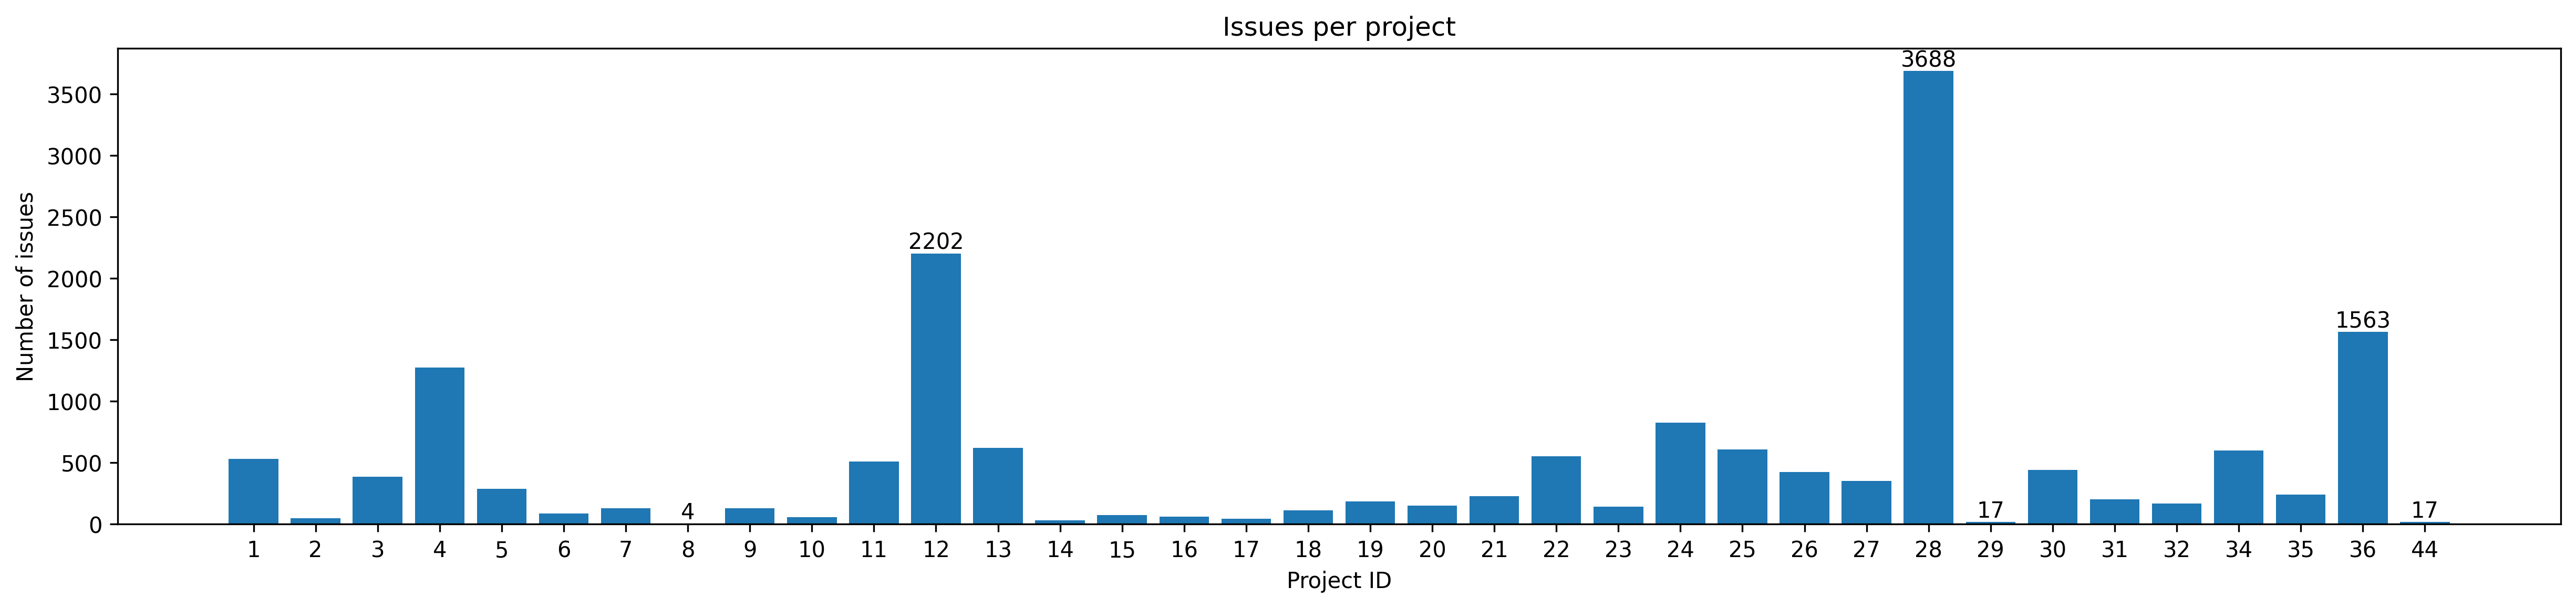

In [ ]:
# Bar chart of issues per project
issues_per_project = [(i, len(pd.unique(j["Issue_ID"]))) for i,j in df.groupby('Project_ID')]
x = [i for i in range(len(issues_per_project))]
h = [i for _,i in issues_per_project]
l = [i for i,_ in issues_per_project]
plt.rcParams["figure.figsize"] = (20,4)
plt.bar(x, h, label=l)
plt.title("Issues per project")
plt.ylabel("Number of issues")
plt.xlabel("Project ID")
plt.xticks(x, l)

#for i in [i for _,i in sorted(zip(h, x))[:3] + sorted(zip(h, x))[-3:]]: <- holbewonerstijl, waarom mag [-3:3] niet?
for i in [i for _,i in [sorted(zip(h, x))[i] for i in range(-3, 3)]]:
  plt.annotate(h[i], xy=(x[i], h[i]), ha='center', va='bottom')

plt.show()

#### Duration per project

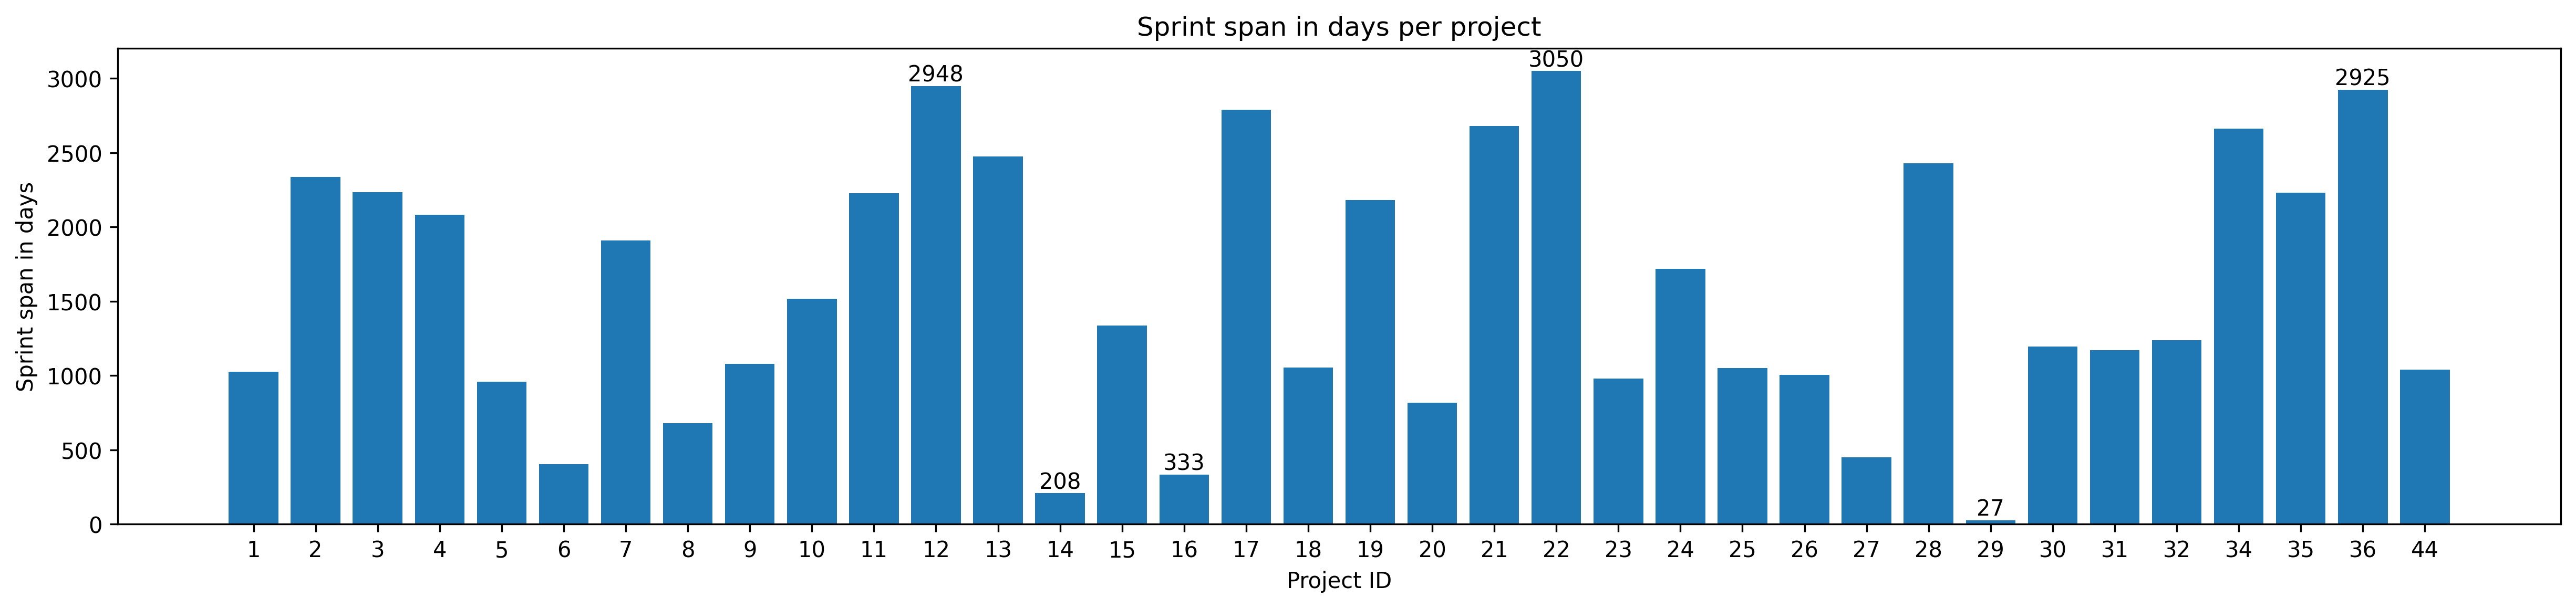

In [ ]:
issues_per_project = [(i, j["End_Date"].max() - j["Start_Date"].where(j['Start_Date'] > pd.to_datetime('1971-01-01')).min()) for i,j in df.groupby('Project_ID')]
x = [i for i in range(len(issues_per_project))]
h = [i.days for _,i in issues_per_project]
l = [i for i,_ in issues_per_project]
plt.rcParams["figure.figsize"] = (20,4)
plt.bar(x, h, label=l)
plt.title("Sprint span in days per project")
plt.ylabel("Sprint span in days")
plt.xlabel("Project ID")
plt.xticks(x, l)

for i in [i for _,i in [sorted(zip(h, x))[i] for i in range(-3, 3)]]:
  plt.annotate(h[i], xy=(x[i], h[i]), ha='center', va='bottom')

plt.show()

#### Timeline per project

In [ ]:
times_per_project = [(i, j['Start_Date'].where(j['Start_Date'] > pd.to_datetime('1970-01-01 00:05:00')).min(), j['End_Date'].max()) for i,j in df.groupby('Project_ID')]
df_tpp = pd.DataFrame(times_per_project)
df_tpp.columns = ["ID", "Start", "End"]
fig = px.timeline(
    df_tpp.sort_values("Start"),
    x_start="Start",
    x_end="End",
    text="ID",
    title="Timeline of projects (no gaps)"
)
fig.show()

#### Sprints per project

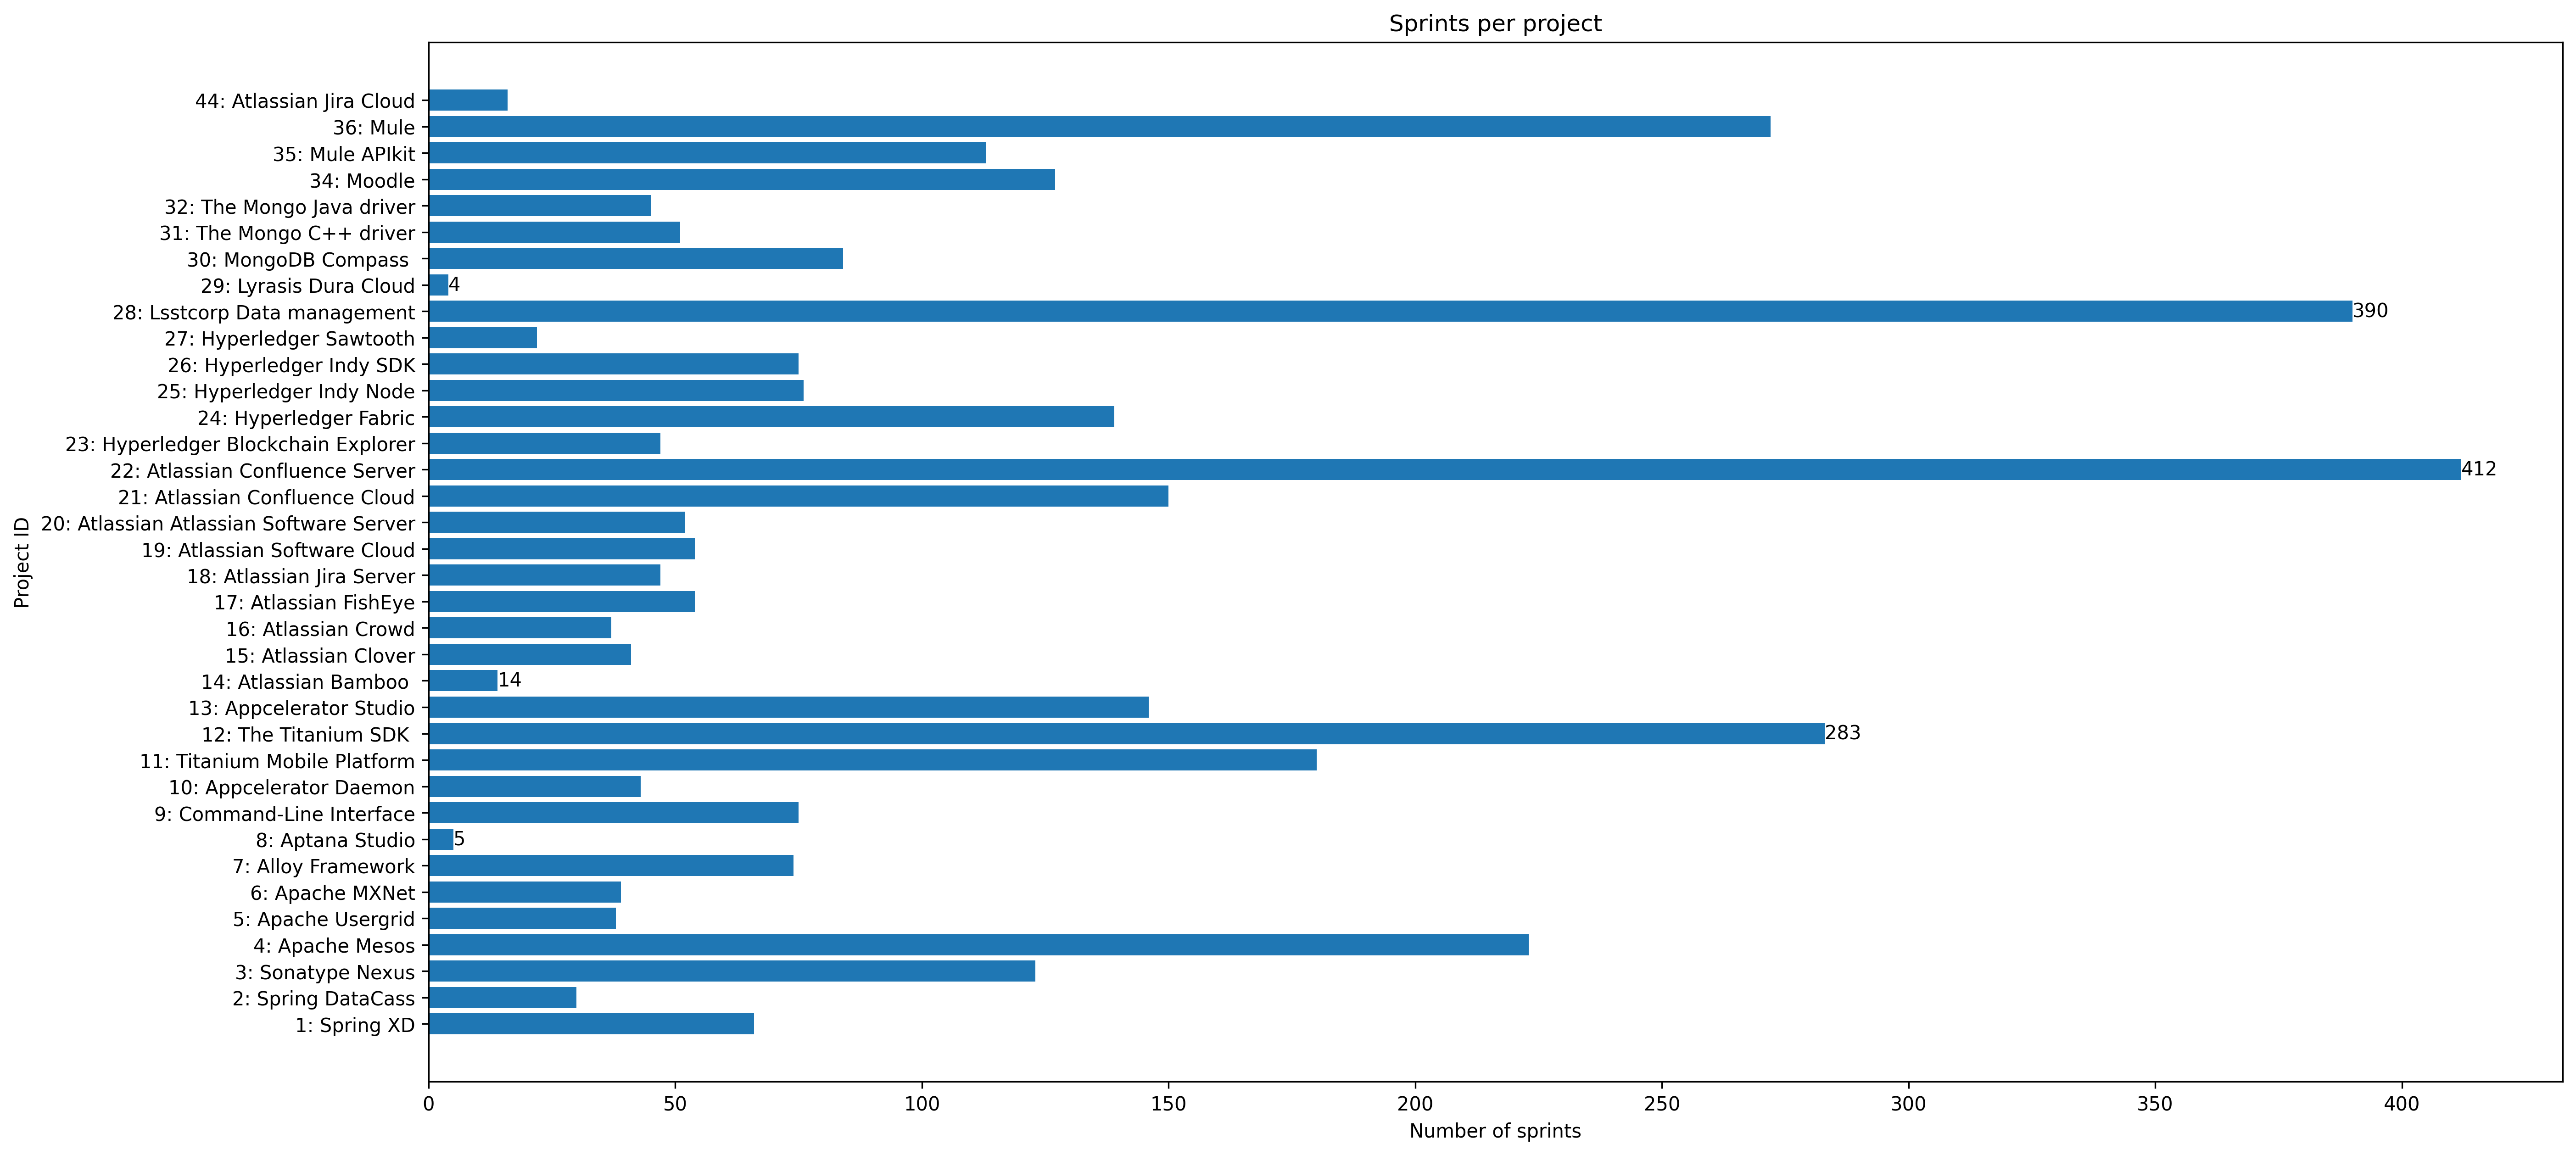

In [ ]:
sprints_per_project = [(i, len(pd.unique(j["Sprint_ID"]))) for i,j in df.groupby('Project_ID')]
x = [i for i in range(len(sprints_per_project))]
h = [i for _,i in sprints_per_project]
l = [i for i,_ in sprints_per_project]
plt.rcParams["figure.figsize"] = (20,10)
plt.barh(x, h, label=l)
plt.title("Sprints per project")
plt.xlabel("Number of sprints")
plt.ylabel("Project ID")
plt.yticks(x, [f"{l[i]}: {id2name[str(l[i])]}" for i in range(len(l))])

for i in [i for _,i in [sorted(zip(h, x))[i] for i in range(-3, 3)]]:
  plt.annotate(h[i], xy=(h[i], x[i]), ha='left', va='center')

plt.show()

#### Percentage of sprints with an issue with no From_Date

In [ ]:
# Pie chart?
df[df["Start_Date"] < pd.to_datetime('1971-01-01 00:05:00')]

,ID,Sprint_ID,Issue_ID,From_Date,To_Date,ID.1,Jira_ID,Issue_Key,URL,Title,Description,Description_Text,Description_Code,Type,Priority,Status,Resolution,Creation_Date,Estimation_Date,Resolution_Date,Last_Updated,Story_Point,Timespent,In_Progress_Minutes,Total_Effort_Minutes,Resolution_Time_Minutes,Title_Changed_After_Estimation,Description_Changed_After_Estimation,Story_Point_Changed_After_Estimation,Pull_Request_URL,Creator_ID,Reporter_ID,Assignee_ID,Project_ID,Sprint_ID.1,ID.2,JiraID,Name,State,Start_Date,End_Date,Activated_Date,Complete_Date,Project_ID.1
11252,15167,1351,63133,2012-02-08 00:06:31,NaT,63133,779621,JSWCLOUD-4503,https://jira.atlassian.com/rest/api/2/issue/779621,"""As a user, I would like to be able to quickly filter issues out in Plan mode""","""{panel:bgColor=#e7f4fa} *NOTE:* This suggestion is for *JIRA Software Cloud*. Using *JIRA Software Server*? [See the corresponding suggestion|http://<USER>atlassian.com/browse/JSWSERVER-4503]. {panel} Quick filters Best Effort is fine for now, probably same as quick filters on Work tab (seems consistent) The marker should still count items above the line even if they are filtered ""","""""""{panel:bgColor=#e7f4fa} *NOTE:* This suggestion is for *JIRA Software Cloud*. Using *JIRA Software Server*? [See the corresponding suggestion|http://<USER>atlassian.com/browse/JSWSERVER-4503]. {panel} Quick filters Best Effort is fine for now, probably same as quick filters on Work tab (seems consistent) The marker should still count items above the line even if they are filtered """"""",NaN,Suggestion,NaN,Closed,Fixed,2012-02-03 04:14:32,2012-02-03 04:14:32,2012-03-09 04:18:00,2019-09-19 07:11:26,8.0,NaN,12973,15770,50403,0,0,0,NaN,21537.0,21537.0,NaN,19,1351,1351,4474,Sprint 1,CLOSED,1970-01-01 00:05:00,1970-01-01 00:06:00,NaT,1970-01-01 00:06:00,19
11253,15168,1350,63133,2012-02-27 00:41:23,NaT,63133,779621,JSWCLOUD-4503,https://jira.atlassian.com/rest/api/2/issue/779621,"""As a user, I would like to be able to quickly filter issues out in Plan mode""","""{panel:bgColor=#e7f4fa} *NOTE:* This suggestion is for *JIRA Software Cloud*. Using *JIRA Software Server*? [See the corresponding suggestion|http://<USER>atlassian.com/browse/JSWSERVER-4503]. {panel} Quick filters Best Effort is fine for now, probably same as quick filters on Work tab (seems consistent) The marker should still count items above the line even if they are filtered ""","""""""{panel:bgColor=#e7f4fa} *NOTE:* This suggestion is for *JIRA Software Cloud*. Using *JIRA Software Server*? [See the corresponding suggestion|http://<USER>atlassian.com/browse/JSWSERVER-4503]. {panel} Quick filters Best Effort is fine for now, probably same as quick filters on Work tab (seems consistent) The marker should still count items above the line even if they are filtered """"""",NaN,Suggestion,NaN,Closed,Fixed,2012-02-03 04:14:32,2012-02-03 04:14:32,2012-03-09 04:18:00,2019-09-19 07:11:26,8.0,NaN,12973,15770,50403,0,0,0,NaN,21537.0,21537.0,NaN,19,1351,1351,4474,Sprint 1,CLOSED,1970-01-01 00:05:00,1970-01-01 00:06:00,NaT,1970-01-01 00:06:00,19
11589,15577,1421,74049,2012-02-08 00:06:31,NaT,74049,163173,JSWSERVER-4503,https://jira.atlassian.com/rest/api/2/issue/163173,"""As a user, I would like to be able to quickly filter issues out in Plan mode""","""{panel:bgColor=#e7f4fa} *NOTE:* This suggestion is for *JIRA Software Server*. Using *JIRA Software Cloud*? [See the corresponding suggestion|http://<USER>atlassian.com/browse/JSWCLOUD-4503]. {panel} Quick filters Best Effort is fine for now, probably same as quick filters on Work tab (seems consistent) The marker should still count items above the line even if they are filtered ""","""""""{panel:bgColor=#e7f4fa} *NOTE:* This suggestion is for *JIRA Software Server*. Using *JIRA Software Cloud*? [See the corresponding suggestion|http://<USER>atlassian.com/browse/JSWCLOUD-4503]. {panel} Quick filters Best Effort is fine for now, probably same as quick filters on Work tab (seems consisten

### Feature exploration

#### Display some rows

In [ ]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
# pd.set_option('display.colheader_justify', 'center')
# pd.set_option('display.precision', 3)
df_dup = df.drop_duplicates(subset='Issue_ID', keep="first") # Drop duplicate issues.

print(f'Number of rows: {df_dup.shape[0]}')

display(df_dup.head(5))

Number of rows: 16978


,ID,Sprint_ID,Issue_ID,From_Date,To_Date,ID.1,Jira_ID,Issue_Key,URL,Title,Description,Description_Text,Description_Code,Type,Priority,Status,Resolution,Creation_Date,Estimation_Date,Resolution_Date,Last_Updated,Story_Point,Timespent,In_Progress_Minutes,Total_Effort_Minutes,Resolution_Time_Minutes,Title_Changed_After_Estimation,Description_Changed_After_Estimation,Story_Point_Changed_After_Estimation,Pull_Request_URL,Creator_ID,Reporter_ID,Assignee_ID,Project_ID,Sprint_ID.1,ID.2,JiraID,Name,State,Start_Date,End_Date,Activated_Date,Complete_Date,Project_ID.1
0,1,2,93,2016-02-12 17:49:16,2016-02-13 19:10:03,93,67652,XD-3740,https://jira.spring.io/rest/api/2/issue/67652,"""Kafka message bus maxWait property is not set up""","""The maxWait property from server.yml in the message bus section for kafka is not propagated through the code, it is ignored.""","""""""The maxWait property from server.yml in the message bus section for kafka is not propagated through the code, it is ignored.""""""",NaN,Bug,Minor,Done,Complete,2016-02-11 17:45:54,2016-02-11 17:45:54,2016-02-21 02:28:22,2016-02-21 02:28:22,1.0,NaN,0,8290,13482,0,0,0,https://github.com/spring-projects/spring-xd/pull/1889,87.0,87.0,91.0,1,1,1,108,Sprint 68,CLOSED,2016-02-16 00:38:45,2016-02-26 08:34:00,NaT,2016-02-26 16:32:19,1
2,3,2,95,NaT,NaT,95,67522,XD-3738,https://jira.spring.io/rest/api/2/issue/67522,"""Encrypt secret information in XD configuration files""","""Spring XD keeps passwords in text files such sas servers.yml, properties files, and module configuration files. Some users have requested a way to store encrypted values rather than clear text. XD should provide a """"hook"""" for users to provide a custom component to detect encrypted property values and decrypt them during container, admin, and module initialization.""","""""""Spring XD keeps passwords in text files such sas servers.yml, properties files, and module configuration files. Some users have requested a way to store encrypted values rather than clear text. XD should provide a """"""""hook"""""""" for users to provide a custom component to detect encrypted property values and decrypt them during container, admin, and module initialization.""""""",NaN,Improvement,Minor,Done,Complete,2016-02-03 09:40:06,2016-02-03 09:40:06,2016-02-16 15:46:51,2016-02-23 18:20:24,2.0,NaN,0,11352,19086,1,0,0,https://github.com/spring-projects/spring-xd/pull/1885,89.0,89.0,89.0,1,1,1,108,Sprint 68,CLOSED,2016-02-16 00:38:45,2016-02-26 08:34:00,NaT,2016-02-26 16:32:19,1
3,9,3,117,2015-12-12 19:47:36,2015-12-17 18:20:24,117,66935,XD-3716,https://jira.spring.io/rest/api/2/issue/66935,"""Support Configuring the RabbitMessageBus MessagePropertiesConverter LongString Limit""","""http://stackoverflow.com/questions/34053997/passing-headerinformation-as-jsonobject-in-header-in-spring-xd""","""""""http://stackoverflow.com/questions/34053997/passing-headerinformation-as-jsonobject-in-header-in-spring-xd""""""",NaN,Improvement,Minor,Done,Complete,2015-12-02 23:15:01,2015-12-02 23:15:01,2016-02-12 22:09:47,2016-02-23 18:19:32,2.0,NaN,100,16136,103614,0,0,0,https://github.com/spring-projects/spring-xd/pull/1880,82.0,82.0,82.0,1,2,2,107,Sprint 67,CLOSED,2016-02-01 17:20:14,2016-02-13 01:16:00,NaT,2016-02-13 19:10:20,1
5,17,4,124,2015-11-21 17:46:00,NaT,124,66818,XD-3709,https://jira.spring.io/rest/api/2/issue/66818,"""Duplicate MBean Names With router Sink""","""For some reason, the Integration {{MBeanExporterHelper}} is not preventing the standard context {{MBeanExporter}} from exporting the {{AbstractMessageRouter}}. This should be suppressed (when an IMBE is present) because it's annotated {{@IntegrationManagedResource}}. Causes {{InstanceAlreadyExistsException}}. Workaround in the stack overflow answer. http://stackoverflow.com/questions/33838502/error-deploying-more-than-one-stream-with-a-router-1-3-0 Could be an SI issue, but investigation needed. However, we should probably include the stream/job name in all MBeans for the stream (a

#### Description length

Description can be used as almost every issue is using it (as expected). \
Description and Description_Text are used equally often, they same to be the same except Description_Text wraps ""..."" around the Description. \
Description_Code however shouldn't be used since it's almost never used.

In [ ]:
# Check how many rows actually use the description.
print(f'Number of rows that use Description: {df_dup["Description"].count()}')
print(f'Number of rows that use Description_Text: {df_dup["Description_Text"].count()}')
print(f'Number of rows that use Description_Code: {df_dup["Description_Code"].count()}')

Number of rows that use Description: 15796
Number of rows that use Description_Text: 15796
Number of rows that use Description_Code: 2781


#### Type

Not sure yet which types we should definitely exclude. What we could exclude:
* Release: only occurs 4x and always without description.
* Test: same as Release.
* Epic: consists of Stories so the issue is basically a composition of other issues. 
* Story: consists of Tasks so also consists of multipe issues. But then how does it make sense that there are much more stories than tasks?
* Task: has Sub-tasks.
* Types that almost never occur so hard to properly analyze (Technical Task, Technical Debt, Documentation, Wish, Test, Sub-task, Test Task, Investigation).

Number of rows that use Type: 16978 

Unique values: ['Bug' 'Improvement' 'Story' 'Technical task' 'Task' 'New Feature'
 'Technical Debt' 'Documentation' 'Epic' 'Wish' 'Test' 'Sub-task'
 'Suggestion' 'Test Task' 'Enhancement Request'] 



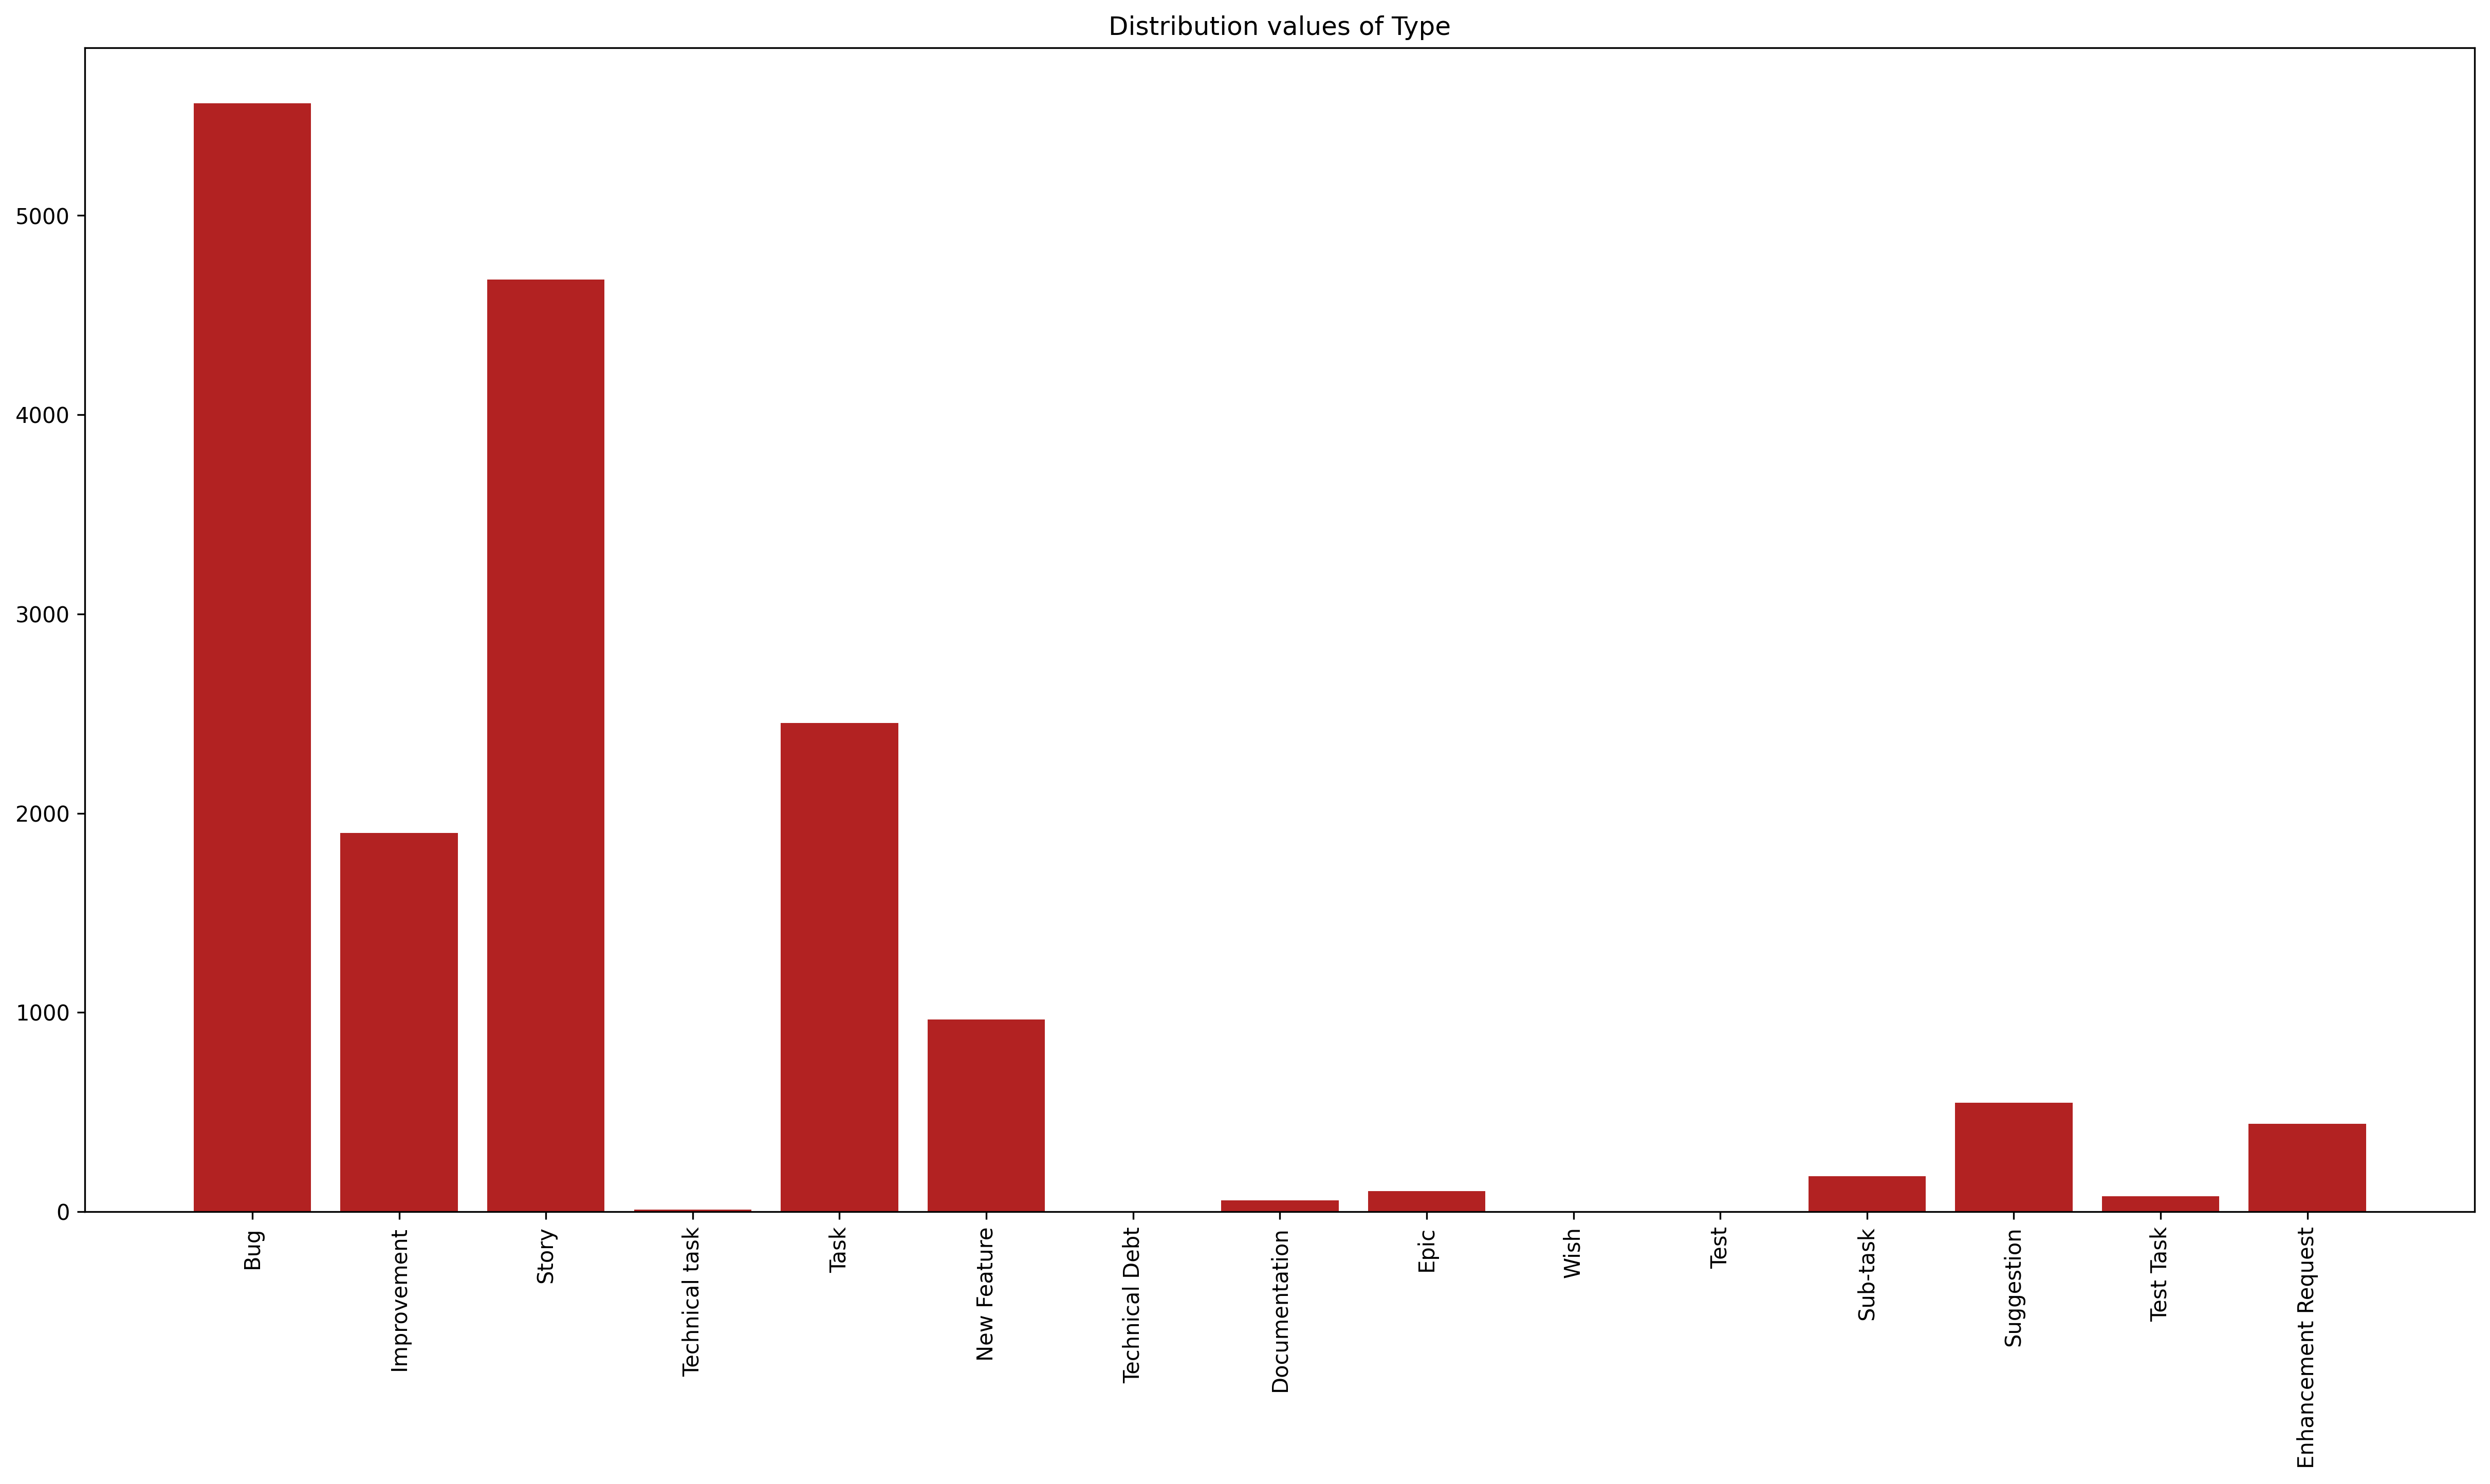

,Description,Type


,Description,Type
1300,"""Cassandra has generally no means to generate Id values as they key is expected to be provided. For cases where the identifier is a monotonicaly incrementing value (e.g. {{long id}}) or a UUID, we could attempt to generate those values. The id value could be backed by a counter table, while UUID's can be generated randomly. We should investigate whether it makes sense to generate identifiers.""",Task
1323,"""Cassandra type resolution is handled currently in {{CassandraMappingContext}} by using annotation-based configuration from {{BasicCassandraPersistentEntity}} and {{BasicCassandraPersistentProperty}}. This arrangement isn't ideal because: # {{CassandraMappingContext}} requires a {{UserTypeResolver}} that uses Cassandra infrastructure to look up type # {{CassandraCustomConversions}} introduces a cycle to {{o.s.d.cassandra.core.convert}}. We should move type resolution to {{CassandraConverter}} entirely to resolve the package cycle and to move the infrastructure dependency to a higher abstraction level. This change would require a switch in dependencies in {{CassandraSessionFactoryBean}}: The factory bean now uses {{CassandraMappingContext}} only to create/drop the schema. After the change, {{CassandraSessionFactoryBean}} requires {{CassandraConverter}}""",Task


,Description,Type
1788,"""Things to address: * -Replace toolbar hack which renders the border in feature header- (implemented in migration2 branch) * -Use {{statics}} to manage modal sizes- (implemented in migration2 branch) * Prefer {{initComponent}} to class refs ([#451|https://github.com/sonatype/nexus-internal/pull/451]) (implemented in master)""",Technical Debt
2240,"""Unsure why we are still using the old version of aether, suggest we update this component to use the latest bits from eclipse.""",Technical Debt


,Description,Type
2508,"""We should add documentation for standalone containers.""",Documentation
2546,NaN,Documentation


,Description,Type
5013,"""We'd like to have expanded variables usable in [the json files used to create a Marathon app, hence] the Task's CommandInfo, so that the executor is able to detect the correct values at runtime.""",Wish
5422,"""As a System Administrator often times I need to run a organization-mandated task on every machine in the cluster. Ideally I could do this within the framework of mesos resources if it is a """"cleanup"""" or auditing task, but sometimes I just have to run something, and run it now, regardless if a machine has un-accounted resources (Ex: Adding/removing a user). Currently to do this I have to completely bypass Mesos and SSH to the box. Ideally I could tell a mesos slave (With proper authentication) to run a container with the limited special permissions needed to get the task done.""",Wish


,Description,Type
7532,NaN,Test


,Description,Type
7672,NaN,Sub-task
10585,"""check manually or extend existing test case""",Sub-task


,Description,Type
10456,"""Place holder for BAM-16590""",Suggestion
10458,"""There are differences in app behaviour between IDEA 14.0.x and 14.1.x. As we're testing Clover against 12.1.7 and 13.0.0, it'd be good to add also 12.0.4, 13.1.6, 14.0.4 to our test matrix. This way we will cover IDEA 12.0, 12.1, 13.0, 13.1, 14.0 and 14.1. """,Suggestion


,Description,Type
18472,"""Now that we've addressed support for all chaincode types, we can begin adding scenarios to test both private data and transient maps. Let's identify which chaincodes we want to run and document them here""",Test Task
18492,"""As it already exists, run the current smoke test suite as part of our nightly test suite in Azure using a VM with Compose. This will provide additional regression coverage until we can migrate existing test scenarios to Operator""",Test Task


,Description,Type


,Description,Type


,Description,Type
37428,"""Add MTF tests to Soapkit""",Enhancement Request
37563,"""Currently OData extension only support one odata model per mule app""",Enhancement Request


In [ ]:
def show_distribution(col_name):
    # Check how many rows actually use this column.
    print(f'Number of rows that use {col_name}: {df_dup[col_name].count()} \n') 
    
    # Find out the possible values for this column.
    possible_values = df_dup[col_name].unique()
    print(f'Unique values: {possible_values} \n')
    possible_values_cleaned = [x for x in possible_values if x == x] # Get rid of NaNs.

    # Plot the distribution of the values.
    frequencies = []

    for value in possible_values_cleaned: 
        frequencies.append(df_dup.query(f"{col_name} == '{value}'").shape[0])

    plt.title(f'Distribution values of {col_name}')
    plt.bar(possible_values_cleaned, frequencies, color='firebrick')
    plt.xticks(rotation=90)
    plt.show()
    
show_distribution('Type')

# Example of unclear types so that we can figure out what they mean.
unclear_types = ['Technical Task', 'Task', 'Technical Debt', 'Documentation', 'Wish',
                 'Test', 'Sub-task', 'Suggestion', 'Test Task', 'Investigation', 'Release', 'Enhancement Request']

for unclear_type in unclear_types:
    display(df_dup.query(f"Type == '{unclear_type}'")[['Description', 'Type']].head(2))

#### Priority

Some overlapping priorities like Minor and 'Minor - P4' or High and Critical.
I suspect that it depends on the project since you can define your own priorities in Jira but have not researched that yet. \
The default on Jira are from Lowest - Low - ... - High - Highest and these are also used more often. \
Maybe good to map them all to the default priorities of Jira.

Number of rows that use Priority: 12740 

Unique values: ['Minor' 'Major' 'Blocker' 'Critical' 'Trivial' 'Medium' 'None' 'High'
 'Low' nan 'Highest' 'Lowest' 'Major - P3' 'Critical - P2' 'Minor - P4'
 'Blocker - P1' 'Trivial - P5' 'To be reviewed'] 



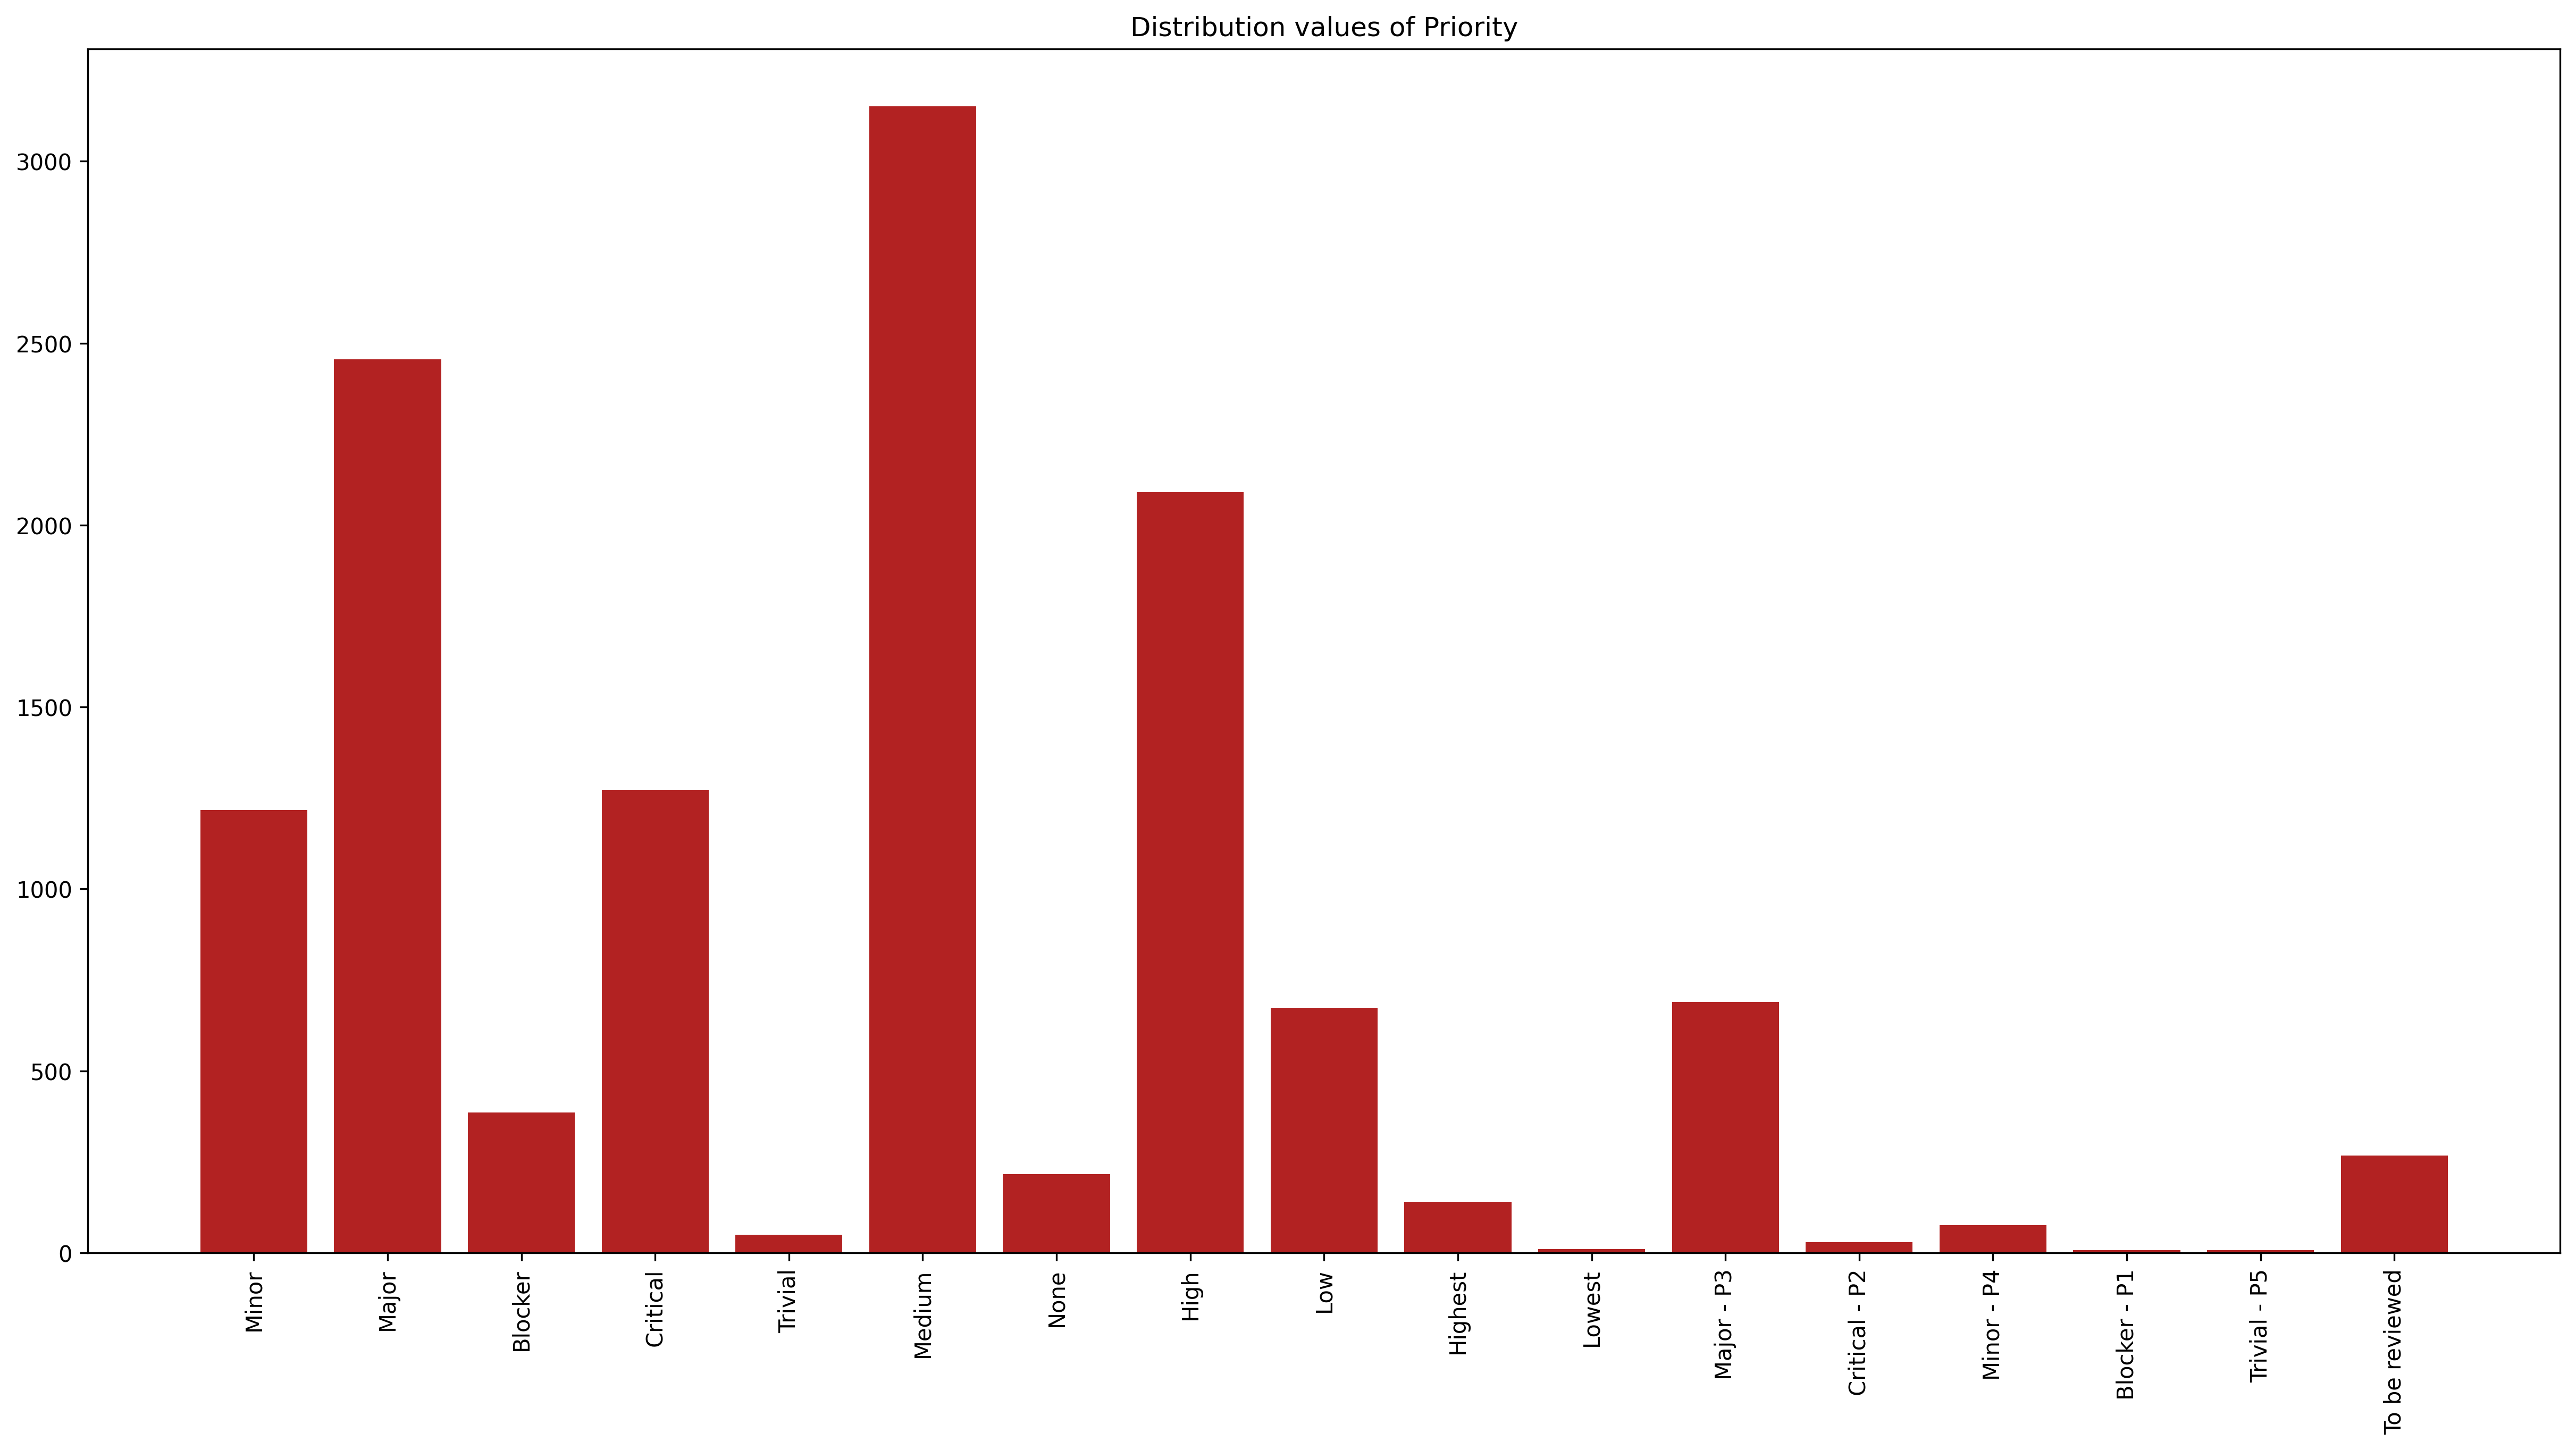

In [ ]:
show_distribution('Priority')

#### Estimated days

Can be useful and most issues have an estimation date.

In [ ]:
# Check how many rows actually use this column.
print(f'Number of rows that use Estimation_Date: {df_dup["Estimation_Date"].count()} \n') 

Number of rows that use Estimation_Date: 12907 



#### Story points

Many issues have story points but huge difference in values, some have 0 points and some have over 6000.
It appears that the issue with story point over 6000 is of type Epic.
Moreover, it's a bit random because there's an issue of type Suggestion that has 3030 story points.
Then there are issues of type Epic with 120 story points and issues of type Improvement with 195 story points.
So Story_Point does not seem very reliable since the estimations are highly dependent on the team and each team may have a different scale.

In [ ]:
# Check how many rows actually use this column.
print(f'Number of rows that use Story_Point: {df_dup["Story_Point"].count()} \n')

print(f'Min value: {df_dup["Story_Point"].min()}')
print(f'Max value: {df_dup["Story_Point"].max()}')
print(f'Average value: {df_dup["Story_Point"].mean()}')
print(f'Variance in values: {df_dup["Story_Point"].var()}')
print(f'Median value: {df_dup["Story_Point"].median()}')

display(df_dup.query(f"Story_Point > 100 and Story_Point < 1000")[['Description', 'Type', 'Story_Point']].head(10))

Number of rows that use Story_Point: 12907 

Min value: 0.0
Max value: 6765.0
Average value: 5.952723328426435
Variance in values: 4291.588429550209
Median value: 4.0


,Description,Type,Story_Point
9062,"""Upgrade Confluence to version 6.3.x to have parity with the rest of the Confluence instances within Axway. Tasks: * Generate a list of plugins installed * Confirmed installed plugins are in use * Deprecate unused plugins * Confirmed active plugins works in the new version of Confluence * Look for CSS style usage and consider what it affects as the classes and element structure is changing * Look for issues with customized layouts post migration * Remove any usage of the space jump macro (deprecated in 6.x) * Dashboards have changed. Confirm the necessity of dashboards and determine impact. * Move Release Notes and blog releases to a new space and implement a style guide, templates, and page hierarchies respectively * Write up an """"End of Support"""" document on the following item: ** Internet Explorer 9 and 10 ** Oracle 11.1 and 11.2 ** Microsoft SQL 2008 ** Android 4.0.3 (Ice Cream Sandwich) mobile browser ** MySQL 5.5 ** Advance notice: View File macros (Office Word, Office PowerPoint, Office Excel, and PDF) ** to-do: Add notes about new/removed features for 6.2.x and 6.3.x * Add children display macro to release note pages as the doc theme is going away and if we want to keep the children page links on the parent release note page, we'll need to add this macro * Generate a list of new features: ** https://confluence.atlassian.com/doc/confluence-5-7-release-notes-692781381.html *** Files are first class citizens *** Inline commenting (just like Google Docs) *** visual roadmaps via the new Roadmap Planner macro *** Smarter profile picture and space logo uploader *** Heading order respected when importing from Word *** Powerful new Content Search REST API (Confluence Query Language (CQL)) **** https://developer.atlassian.com/display/CONFDEV/Advanced+Searching+using+CQL ** https://confluence.atlassian.com/doc/confluence-5-8-release-notes-744325370.html *** Preview or download from the attachments macro *** Table updates *** Content by Label and Page Properties Report macros updates ** https://confluence.atlassian.com/doc/confluence-5-10-release-notes-826894762.html *** User permission changes *** Batched notifications *** Add and remove space watchers *** New software project space blueprint Resources: * https://confluence.atlassian.com/doc/confluence-6-0-upgrade-notes-844235311.html * https://confluence.atlassian.com/doc/confluence-6-1-upgrade-notes-872277793.html * https://confluence.atlassian.com/doc/documentation-theme-migration-faq-847355042.html * https://confluence.atlassian.com/doc/confluence-5-9-upgrade-notes-788955921.html#Confluence5.9UpgradeNotes-Dashboardchanges * https://confluence.atlassian.com/doc/confluence-6-1-upgrade-notes-872277793.html * https://developer.atlassian.com/display/CONFDEV/Advanced+Searching+using+CQL * https://confluence.atlassian.com/doc/confluence-5-7-release-notes-692781381.html * https://confluence.atlassian.com/doc/confluence-5-8-release-notes-744325370.html * https://confluence.atlassian.com/doc/confluence-5-10-release-notes-826894762.html""",Epic,120.0
33023,"""Deliverable: evaluation of Cinder as OpenStack storage cache in the LSST Middleware Daues G 100%"""" """,Epic,113.0
36632,"""UCLA have submitted some code for an updated view of the gradebook and it looks that we may accept this into core. It still needs a little bit of work as part of this issue including: * Merge existing commits where relevant * Update to meet coding style guidelines (Primarily JS) * Move hardcoded styles to css * Check SASS and produce a definitive CSS/Less set (as appropriate) and remove SASS files again There may be more...""",Improvement,195.0


#### Are story points fibonacci?

In [ ]:
for i,d in df_dup.groupby("Project_ID"):
  print(f"{i}: {sorted([i for i in pd.unique(d['Story_Point']) if i == i])}")

1: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 10.0, 12.0, 13.0, 15.0, 16.0, 20.0, 40.0]
2: [0.0, 1.0, 3.0, 5.0, 8.0]
3: [0.0, 0.5, 1.0, 2.0, 3.0, 5.0, 8.0, 13.0]
4: [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 12.0, 13.0]
5: [0.0, 1.0, 2.0, 3.0, 5.0, 8.0]
6: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 8.0, 13.0, 32.0]
7: [1.0, 2.0, 3.0, 5.0, 8.0, 13.0]
8: [5.0]
9: [0.0, 1.0, 2.0, 3.0, 5.0, 8.0, 13.0]
10: [1.0, 2.0, 3.0, 5.0, 8.0, 13.0, 21.0, 31.0, 33.0, 34.0, 55.0]
11: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 11.0, 12.0, 13.0, 14.0, 16.0, 18.0, 21.0, 22.0, 24.0, 34.0, 120.0]
12: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0, 9.0, 11.0, 13.0, 15.0, 17.0, 20.0, 21.0, 23.0, 34.0, 42.0, 63.0, 6765.0]
13: [0.0, 1.0, 2.0, 3.0, 5.0, 8.0, 9.0, 13.0, 21.0]
14: []
15: [0.0, 0.5, 1.0, 2.0, 3.0, 5.0, 8.0, 13.0, 20.0]
16: [0.5, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
17: [0.0, 0.5, 1.0, 2.0, 2.5, 3.0]
18: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0]
19: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 8.0, 13.0, 20.0]
20: [0.0, 1

#### Number of comments

#### Average comment length

#### Link type

#### Link direction

#### Sprint days given

In [ ]:
# Check how many rows actually use this column.
print(f'Number of rows that use End_Date: {df_dup["End_Date"].count()} \n') 

Number of rows that use End_Date: 16519 



### RQ1: Best practice analysis

#### Team size between 3-8 people

For now, we make the assumption the teamsize equals the number of people working in the sprint which equals the number of unique creators, reporters and assignees of every issue in that sprint.

If we agree on this assumption, then we can maybe visualize a stacked bar chart where we show for each project, the number of sprints that have team size < 3, team size between 3 and 8, team size > 8.

Number of sprints that have team size of fewer than 3 people: 963
Number of sprints that have team size between 3 and 8 people: 1506
Number of sprints that have team size of more than 8 people: 381


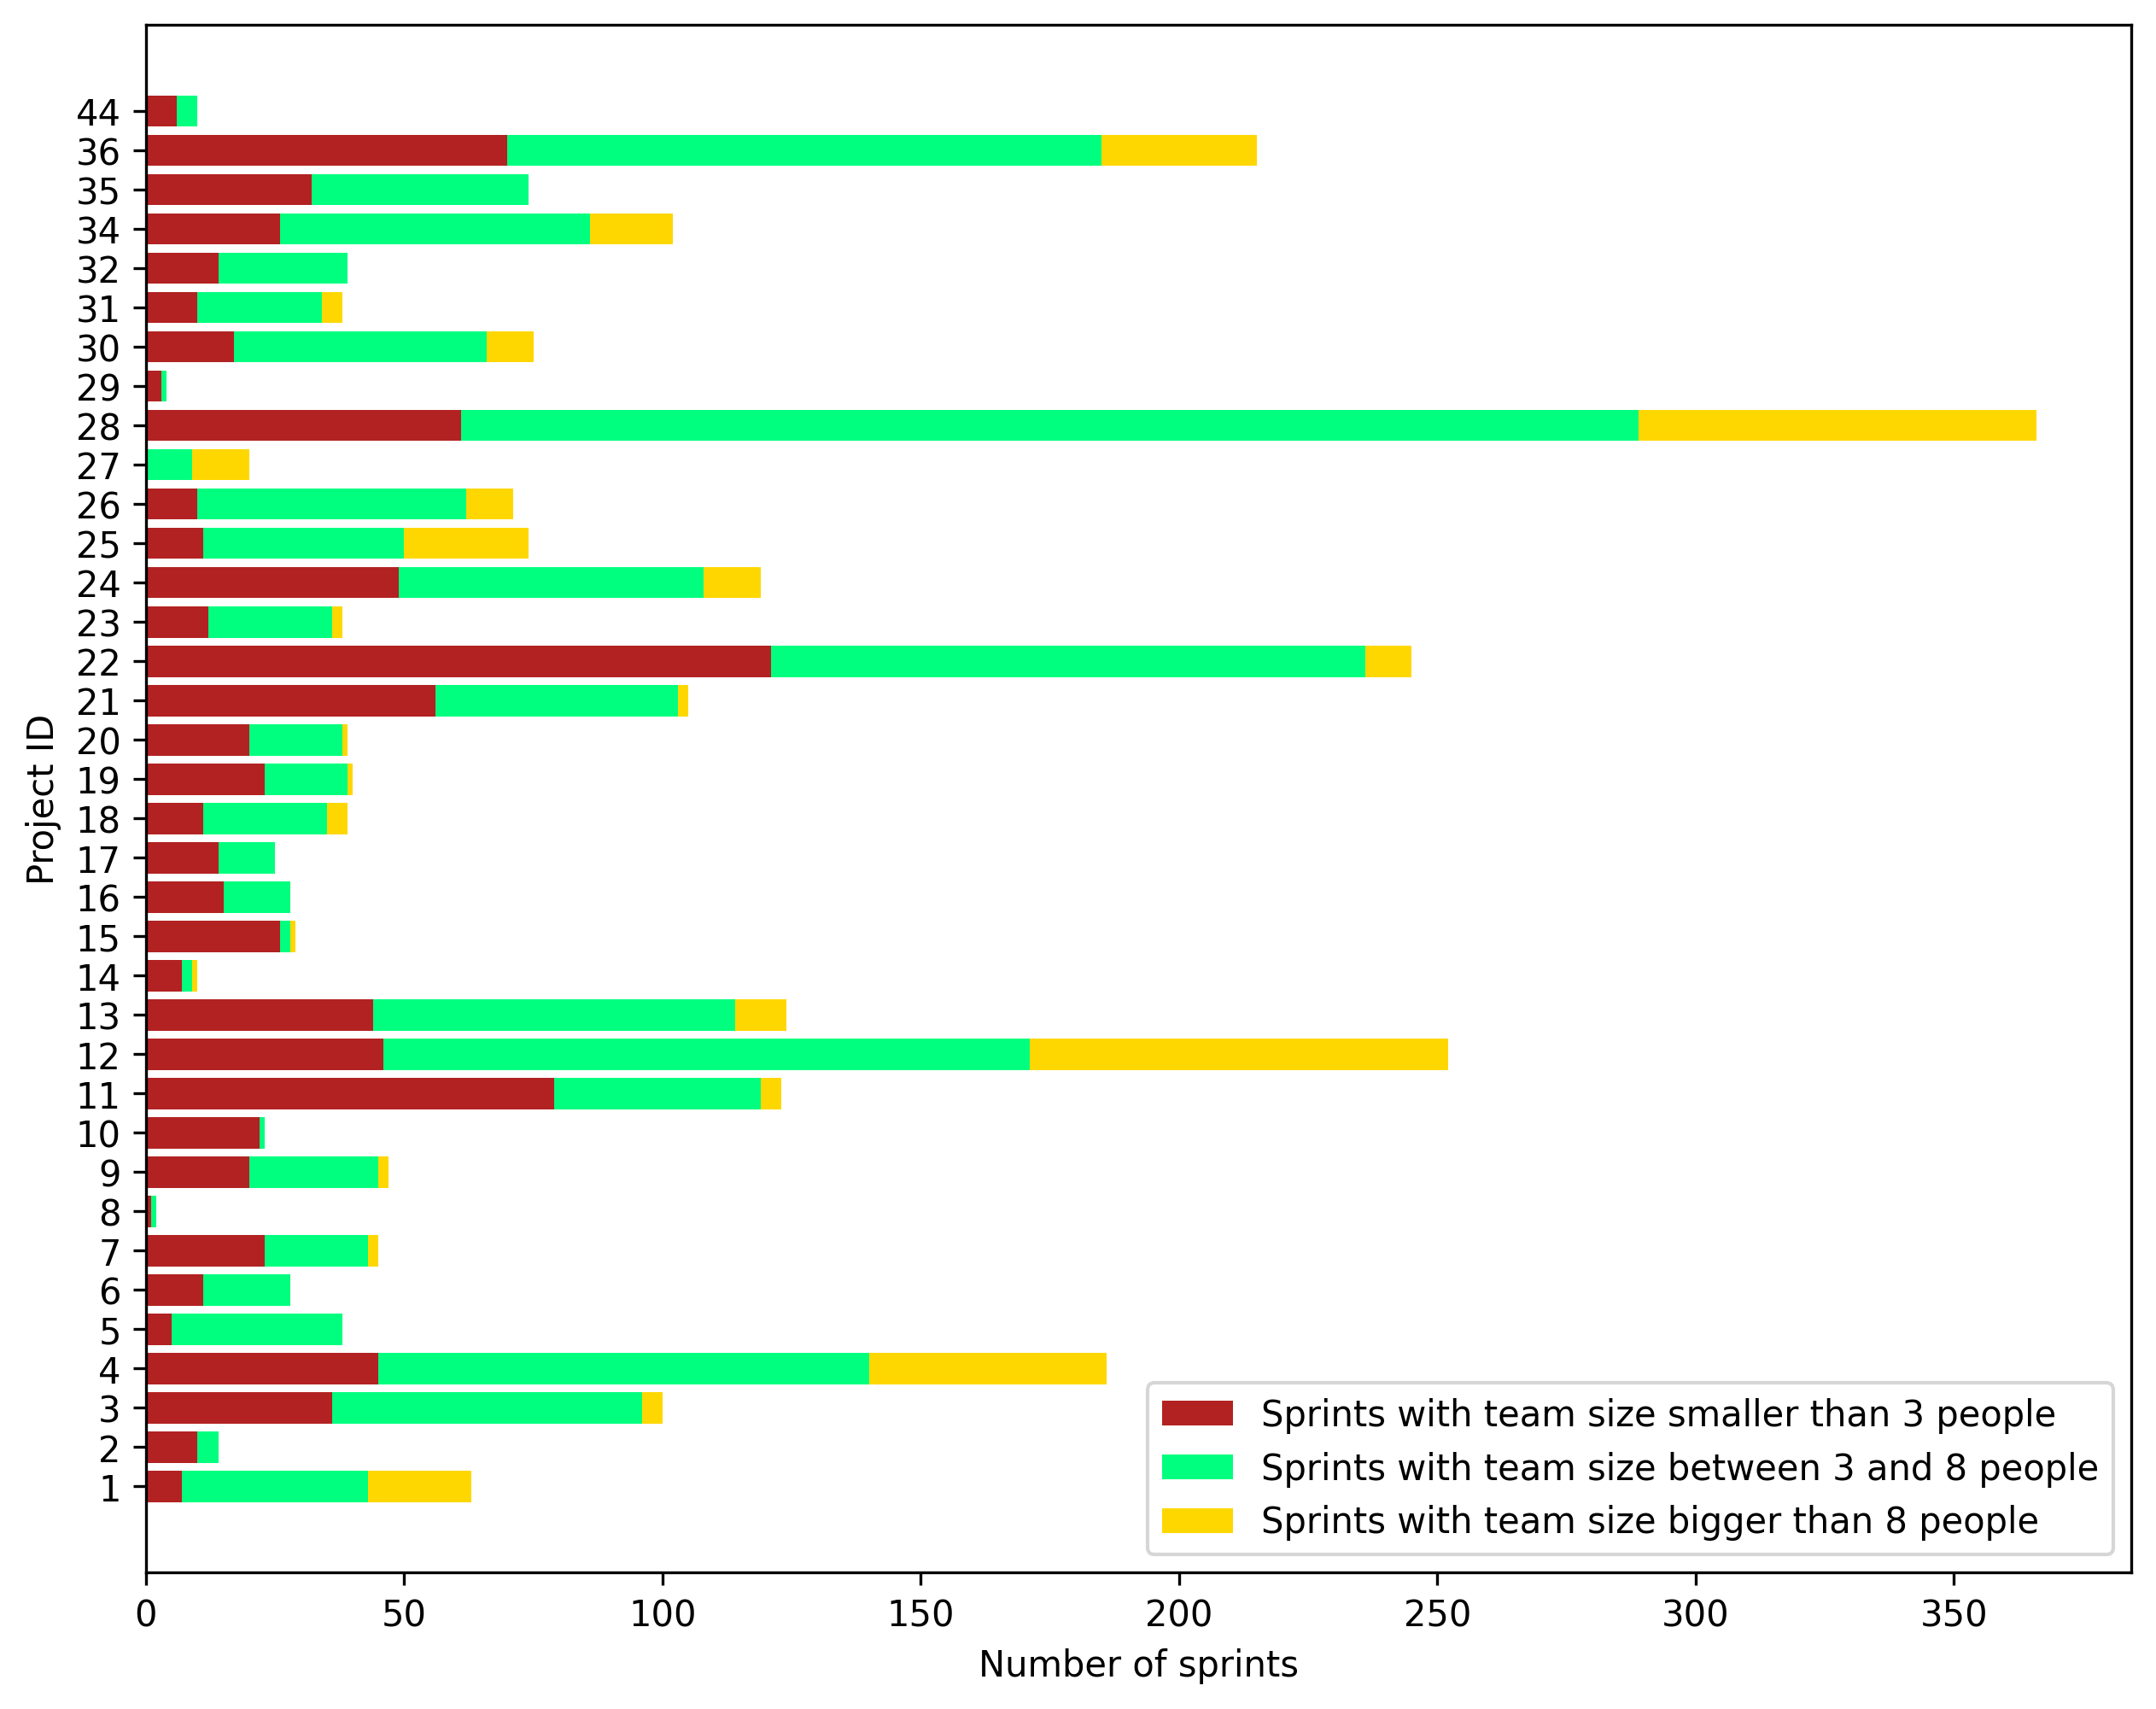

In [ ]:
from matplotlib.offsetbox import HPacker
num_less_three = 0
num_between = 0
num_greater_eight = 0

projectIDs = sorted(df_dup['Project_ID'].unique())

dict_less_three = {}
dict_between = {}
dict_greater_eight = {}

for id in projectIDs:
    dict_less_three[id] = 0
    dict_between[id] = 0
    dict_greater_eight[id] = 0

for i,d in df_dup.groupby("Project_ID"):
    for j,s in d.groupby("Sprint_ID"):
        unique_creators = list(s['Creator_ID'].unique())
        unique_reporters = list(s['Reporter_ID'].unique())
        unique_assignees = list(s['Assignee_ID'].unique())
        unique_people = set(unique_creators + unique_reporters + unique_assignees)
        num_unique_people = len({x for x in unique_people if pd.notna(x)}) # Remove nan values.
        
        if num_unique_people < 3:
            num_less_three += 1
            dict_less_three[i] += 1
        elif num_unique_people >= 3 and num_unique_people <=8:
            num_between += 1
            dict_between[i] +=1
        else:
            num_greater_eight += 1
            dict_greater_eight[i] += 1
   
        # print(f"Project {i}, sprint {j}: {num_unique_people}")

print(f"Number of sprints that have team size of fewer than 3 people: {num_less_three}")
print(f"Number of sprints that have team size between 3 and 8 people: {num_between}")
print(f"Number of sprints that have team size of more than 8 people: {num_greater_eight}")

# 
less_three_per_project = list(dict_less_three.items())
between_per_project = list(dict_between.items())
greater_eight_per_project = list(dict_greater_eight.items())

x = [i for i in range(len(less_three_per_project))]
h = [i for _,i in less_three_per_project]
l = [i for i,_ in less_three_per_project]

x2 = [i for i in range(len(between_per_project))]
h2 = [i for _,i in between_per_project]
l2 = [i for i,_ in between_per_project]

x3 = [i for i in range(len(greater_eight_per_project))]
h3 = [i for _,i in greater_eight_per_project]
l3 = [i for i,_ in greater_eight_per_project]

plt.rcParams["figure.figsize"] = (10, 8)
plt.barh(x, h, color='firebrick', label='Sprints with team size smaller than 3 people')
plt.barh(x, h2, color='springgreen', left=h, label='Sprints with team size between 3 and 8 people')
plt.barh(x, h3, color='gold', left=np.array(h)+np.array(h2), label='Sprints with team size bigger than 8 people')
# plt.title("Distribution of sprint team size (stacked)")
plt.xlabel("Number of sprints")
plt.ylabel("Project ID")
plt.legend()
plt.yticks(x, [f"{l[i]}" for i in range(len(l))])
plt.show()

#### Fixed length

TODO: Histogram of standard deviation of sprint lengths per projectID.

In [ ]:
# for i,d in df_dup.groupby("Project_ID"):
#   sprint_lengths = []
#   for j,s in d.groupby("Sprint_ID"):
#     mind = min(s["Start_Date"])
#     maxd = max(s["End_Date"])
#     # print(f"Project {i} sprint {j}: {mind} -> {maxd} = {(maxd-mind).ceil('d').days} days")
#     sprint_lengths.append(maxd - mind)
#   sl_days = [i.ceil('d').days for i in sprint_lengths]
#   sl_days = [i for i in sl_days if str(i) != 'nan'] #???
#   b = max(sl_days) - min(sl_days)
#   b = b if b>0 else 1 #???
#   plt.hist(sl_days, density=True, bins=b)
#   plt.title(f"Project {i}")
#   plt.show()

In [ ]:
sprint_day = df_dup[["Sprint_ID","Start_Date","End_Date","Project_ID"]].dropna()
day_num = pd.DataFrame(columns =  ["Project ID", "# Days"])
for i,j in sprint_day.groupby("Project_ID"):
  for s,t in j.groupby("Sprint_ID"):
    mind = min(t["Start_Date"])
    maxd = max(t["End_Date"])
    dayNumber = (maxd-mind).days
    day_num.loc[len(day_num)] = [i, dayNumber]
print(day_num)

     Project ID # Days
0             1     10
1             1     11
2             1     11
3             1     11
4             1     25
...         ...    ...
2828         44     10
2829         44     13
2830         44     13
2831         44     12
2832         44     13

[2833 rows x 2 columns]


In [ ]:
iqr_per_proj = pd.DataFrame(columns =  ["Project ID", "IQR"])
for i,v in day_num.groupby('Project ID'):
  iqr = v['# Days'].quantile(0.75) - v['# Days'].quantile(0.25)
  # print(iqr)
  iqr_per_proj.loc[len(iqr_per_proj)] = [int(i), iqr]

print(iqr_per_proj[iqr_per_proj["IQR"] > 70].shape[0])
print(iqr_per_proj[iqr_per_proj["IQR"] <= 7].shape[0])
plt.rcParams["figure.figsize"] = (10, 8)

12
8


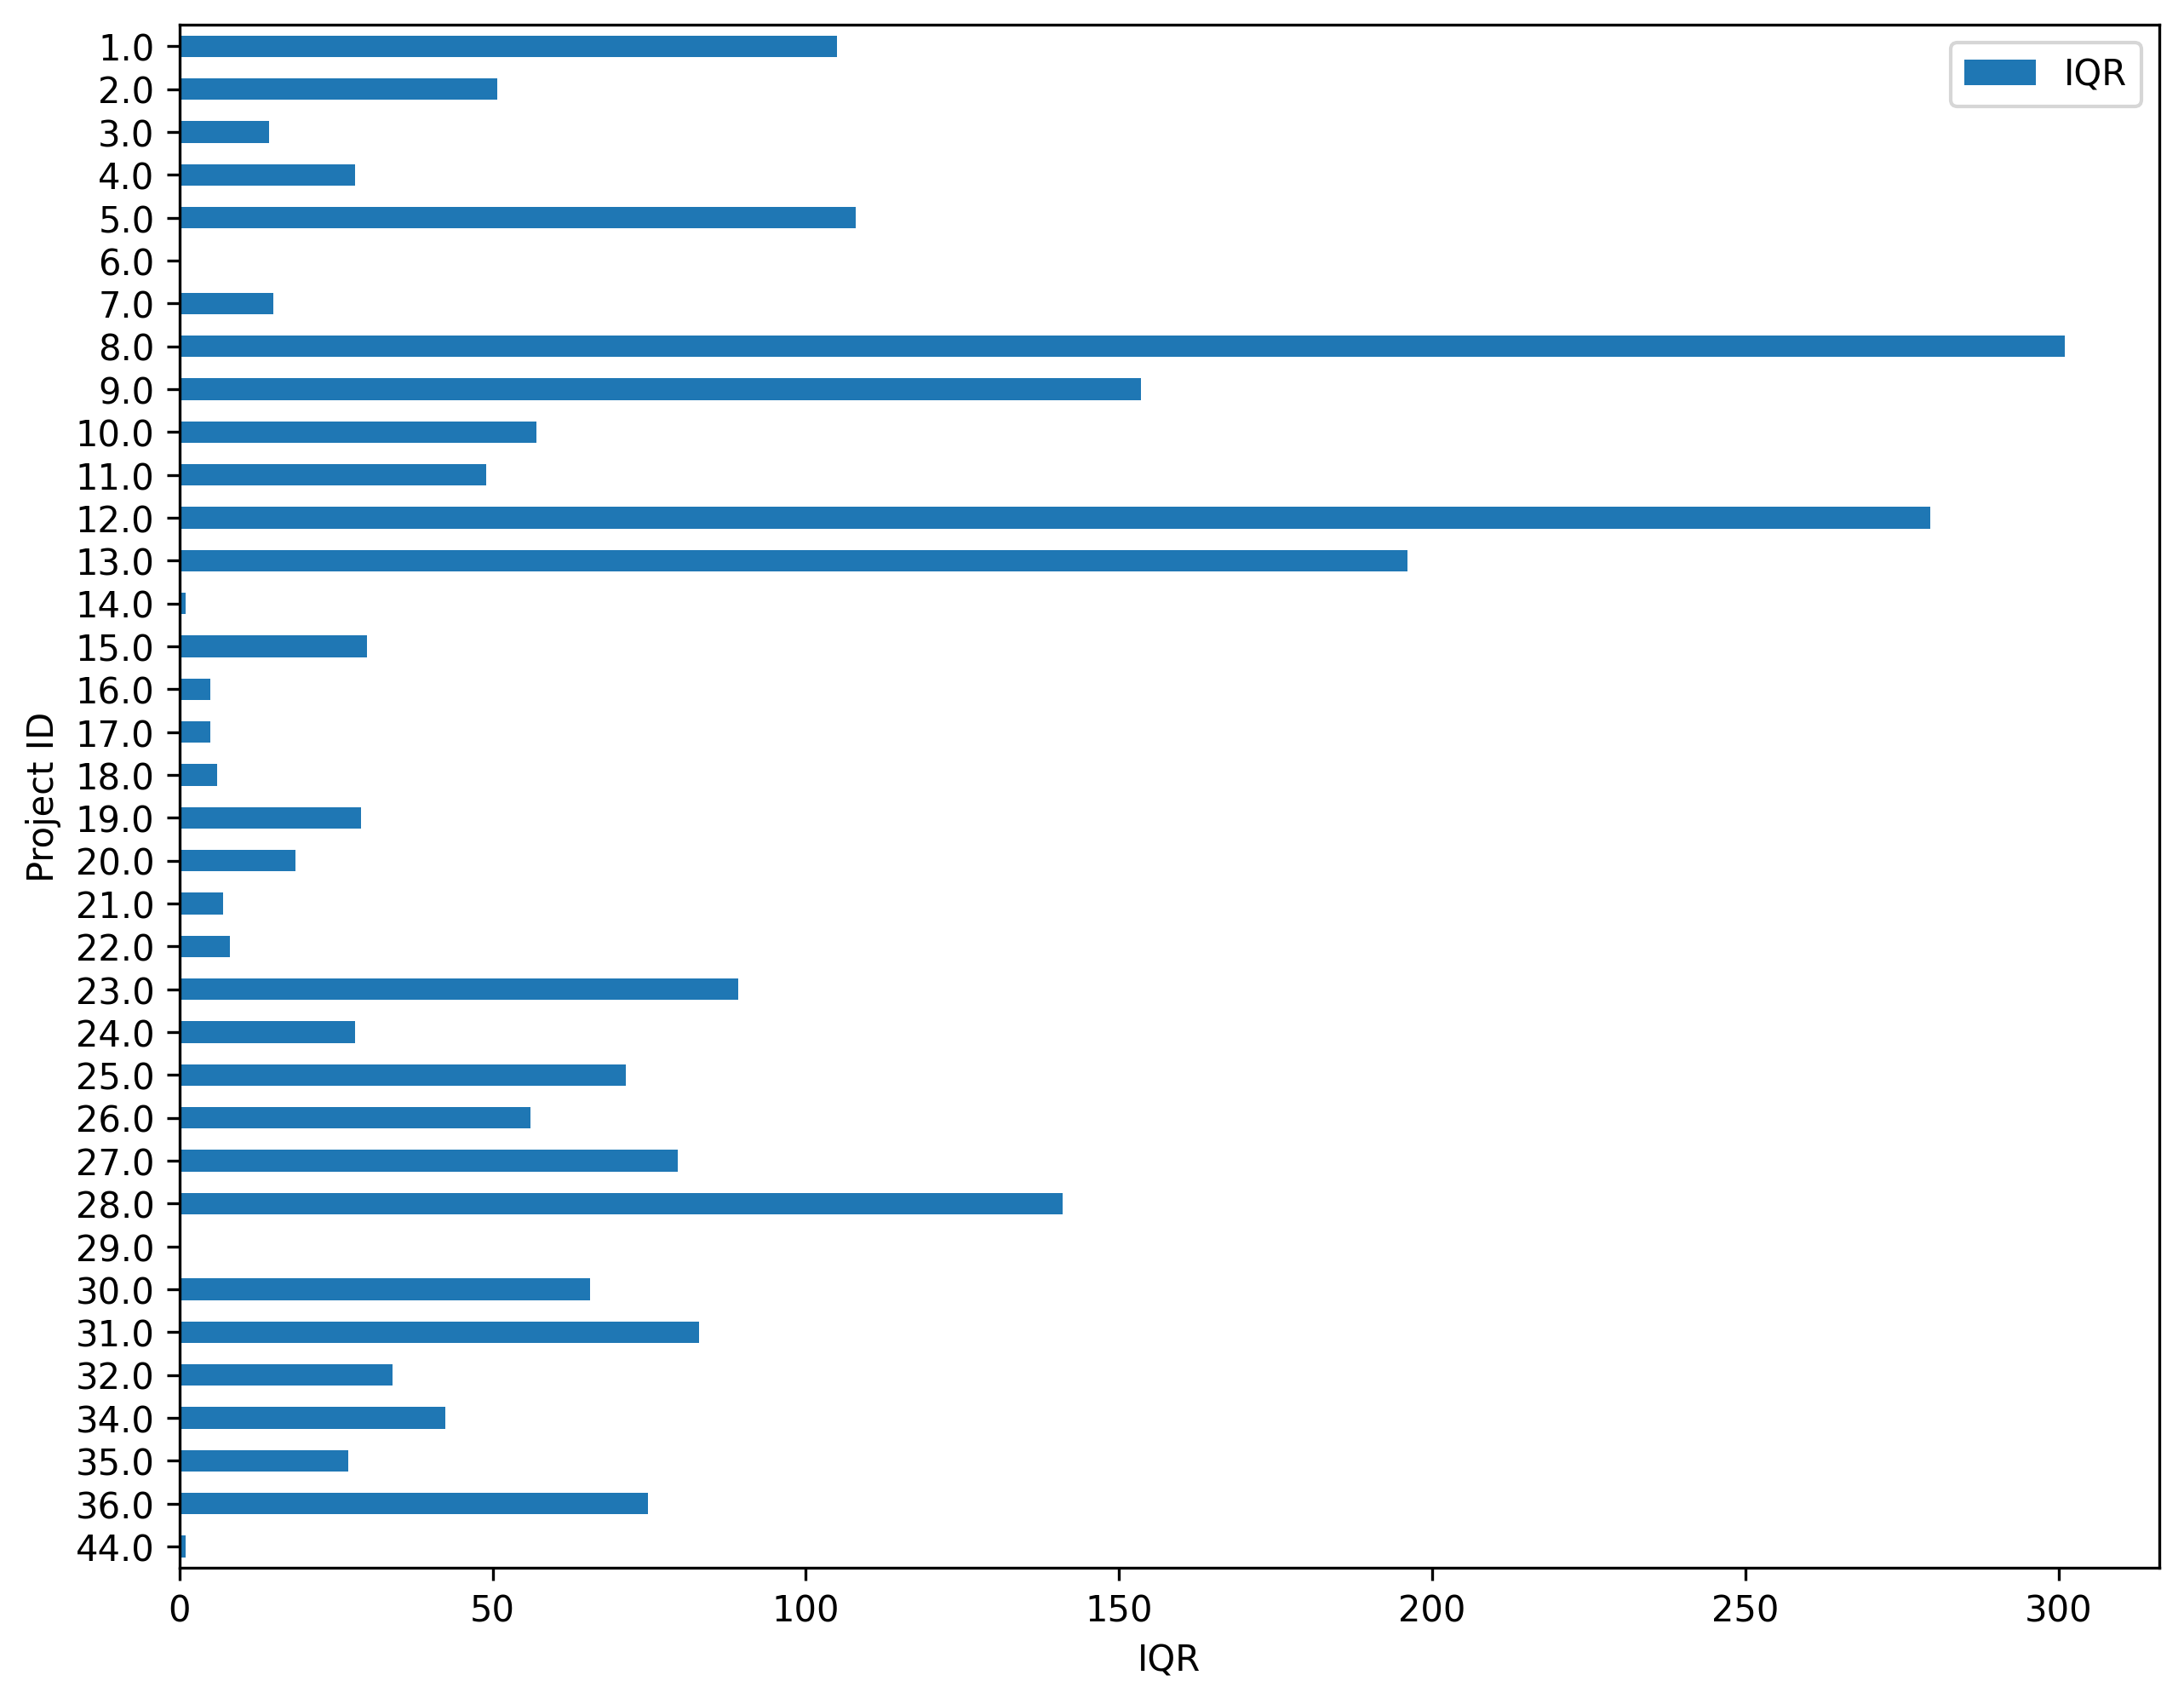

In [ ]:
grouped = iqr_per_proj # .groupby('Project ID').std()
grouped.plot.barh(x = "Project ID").invert_yaxis()
plt.xlabel('IQR')
plt.ylabel('Project ID')
plt.show()

#### Sprint length between 1 and 4 weeks

TODO: Make stacked bar chart with on x-axis the project ID and on y-axis stacked bars (number of sprints in that project with length 1/4 weeks and number of springs >4 weeks).

In [ ]:
import statistics

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
                  # , Bbox = dict(facecolor = 'red', alpha =.8))

# Drop rows without value
sprint_week = df_dup[["Sprint_ID","Start_Date","End_Date","Project_ID"]].dropna()
week_num = pd.DataFrame(columns =  ["Project_ID", "<2 Weeks", "1~3 Weeks", ">3 Weeks"])
project_median = []
for i,v in sprint_week.groupby("Project_ID"):
  weeksday = []
  less_than_two = 0
  two_to_three = 0
  more_than_four = 0
  for s,t in v.groupby("Sprint_ID"):
    mind = min(t["Start_Date"])
    maxd = max(t["End_Date"])
    week = (maxd-mind).days/7
    weeksday.append(week)
    if week > 3:
      more_than_four += 1
    elif week >= 2 and week <= 3:
      two_to_three += 1
    elif week <2:
      less_than_two += 1
  week_num.loc[len(week_num)] = [i, less_than_two, two_to_three, more_than_four]
  project_median.append(int(statistics.median(weeksday)))

week_num_stat = pd.DataFrame(columns =  ['Not 2~3'])

week_num_stat['Not 2~3'] = week_num['<2 Weeks'] + week_num['>3 Weeks']
week_num_stat['1~3 Weeks'] = week_num['1~3 Weeks']
week_num_stat['<2 Weeks'] = week_num['<2 Weeks']
week_num_stat['>3 Weeks'] = week_num['>3 Weeks']

week_num_stat['between 2&3'] = week_num_stat['1~3 Weeks']/(week_num_stat['Not 2~3'] + week_num_stat['1~3 Weeks'])* 100
week_num_stat['not 2&3'] = (week_num_stat['Not 2~3'])/(week_num_stat['Not 2~3'] + week_num_stat['1~3 Weeks'])* 100
# week_num_stat['<2'] = week_num_stat['<2 Weeks']/(week_num_stat['Not 2~3'] + week_num_stat['1~3 Weeks'])* 100
# week_num_stat['>3'] = week_num_stat['>3 Weeks']/(week_num_stat['Not 2~3'] + week_num_stat['1~3 Weeks'])* 100
# print(week_num[week_num["between 2&3"] >50].shape[0])
# print(week_num)
print(week_num_stat['<2 Weeks'].mean())
print(week_num_stat['<2 Weeks'].median())
print(week_num_stat['1~3 Weeks'].mean())
print(week_num_stat['1~3 Weeks'].median())
print(week_num_stat['>3 Weeks'].mean())
print(week_num_stat['>3 Weeks'].median())
print(week_num)
print(week_num_stat)

31.916666666666668
19.5
7.444444444444445
5.0
39.333333333333336
20.5
   Project_ID <2 Weeks 1~3 Weeks >3 Weeks
0           1       14         3       46
1           2        4         0       10
2           3       56         2       42
3           4       97        11       78
4           5        8         8       20
5           6       22         0        6
6           7       23         1       21
7           8        1         0        1
8           9       16         7       24
9          10       11         1       11
10         11       69         9       44
11         12       80        14      158
12         13       37         1       86
13         14        6         3        0
14         15        9         8       12
15         16       24         2        2
16         17        7        14        4
17         18       29         0       10
18         19       16         8       16
19         20       17        11       11
20         21       86         6       13
21    

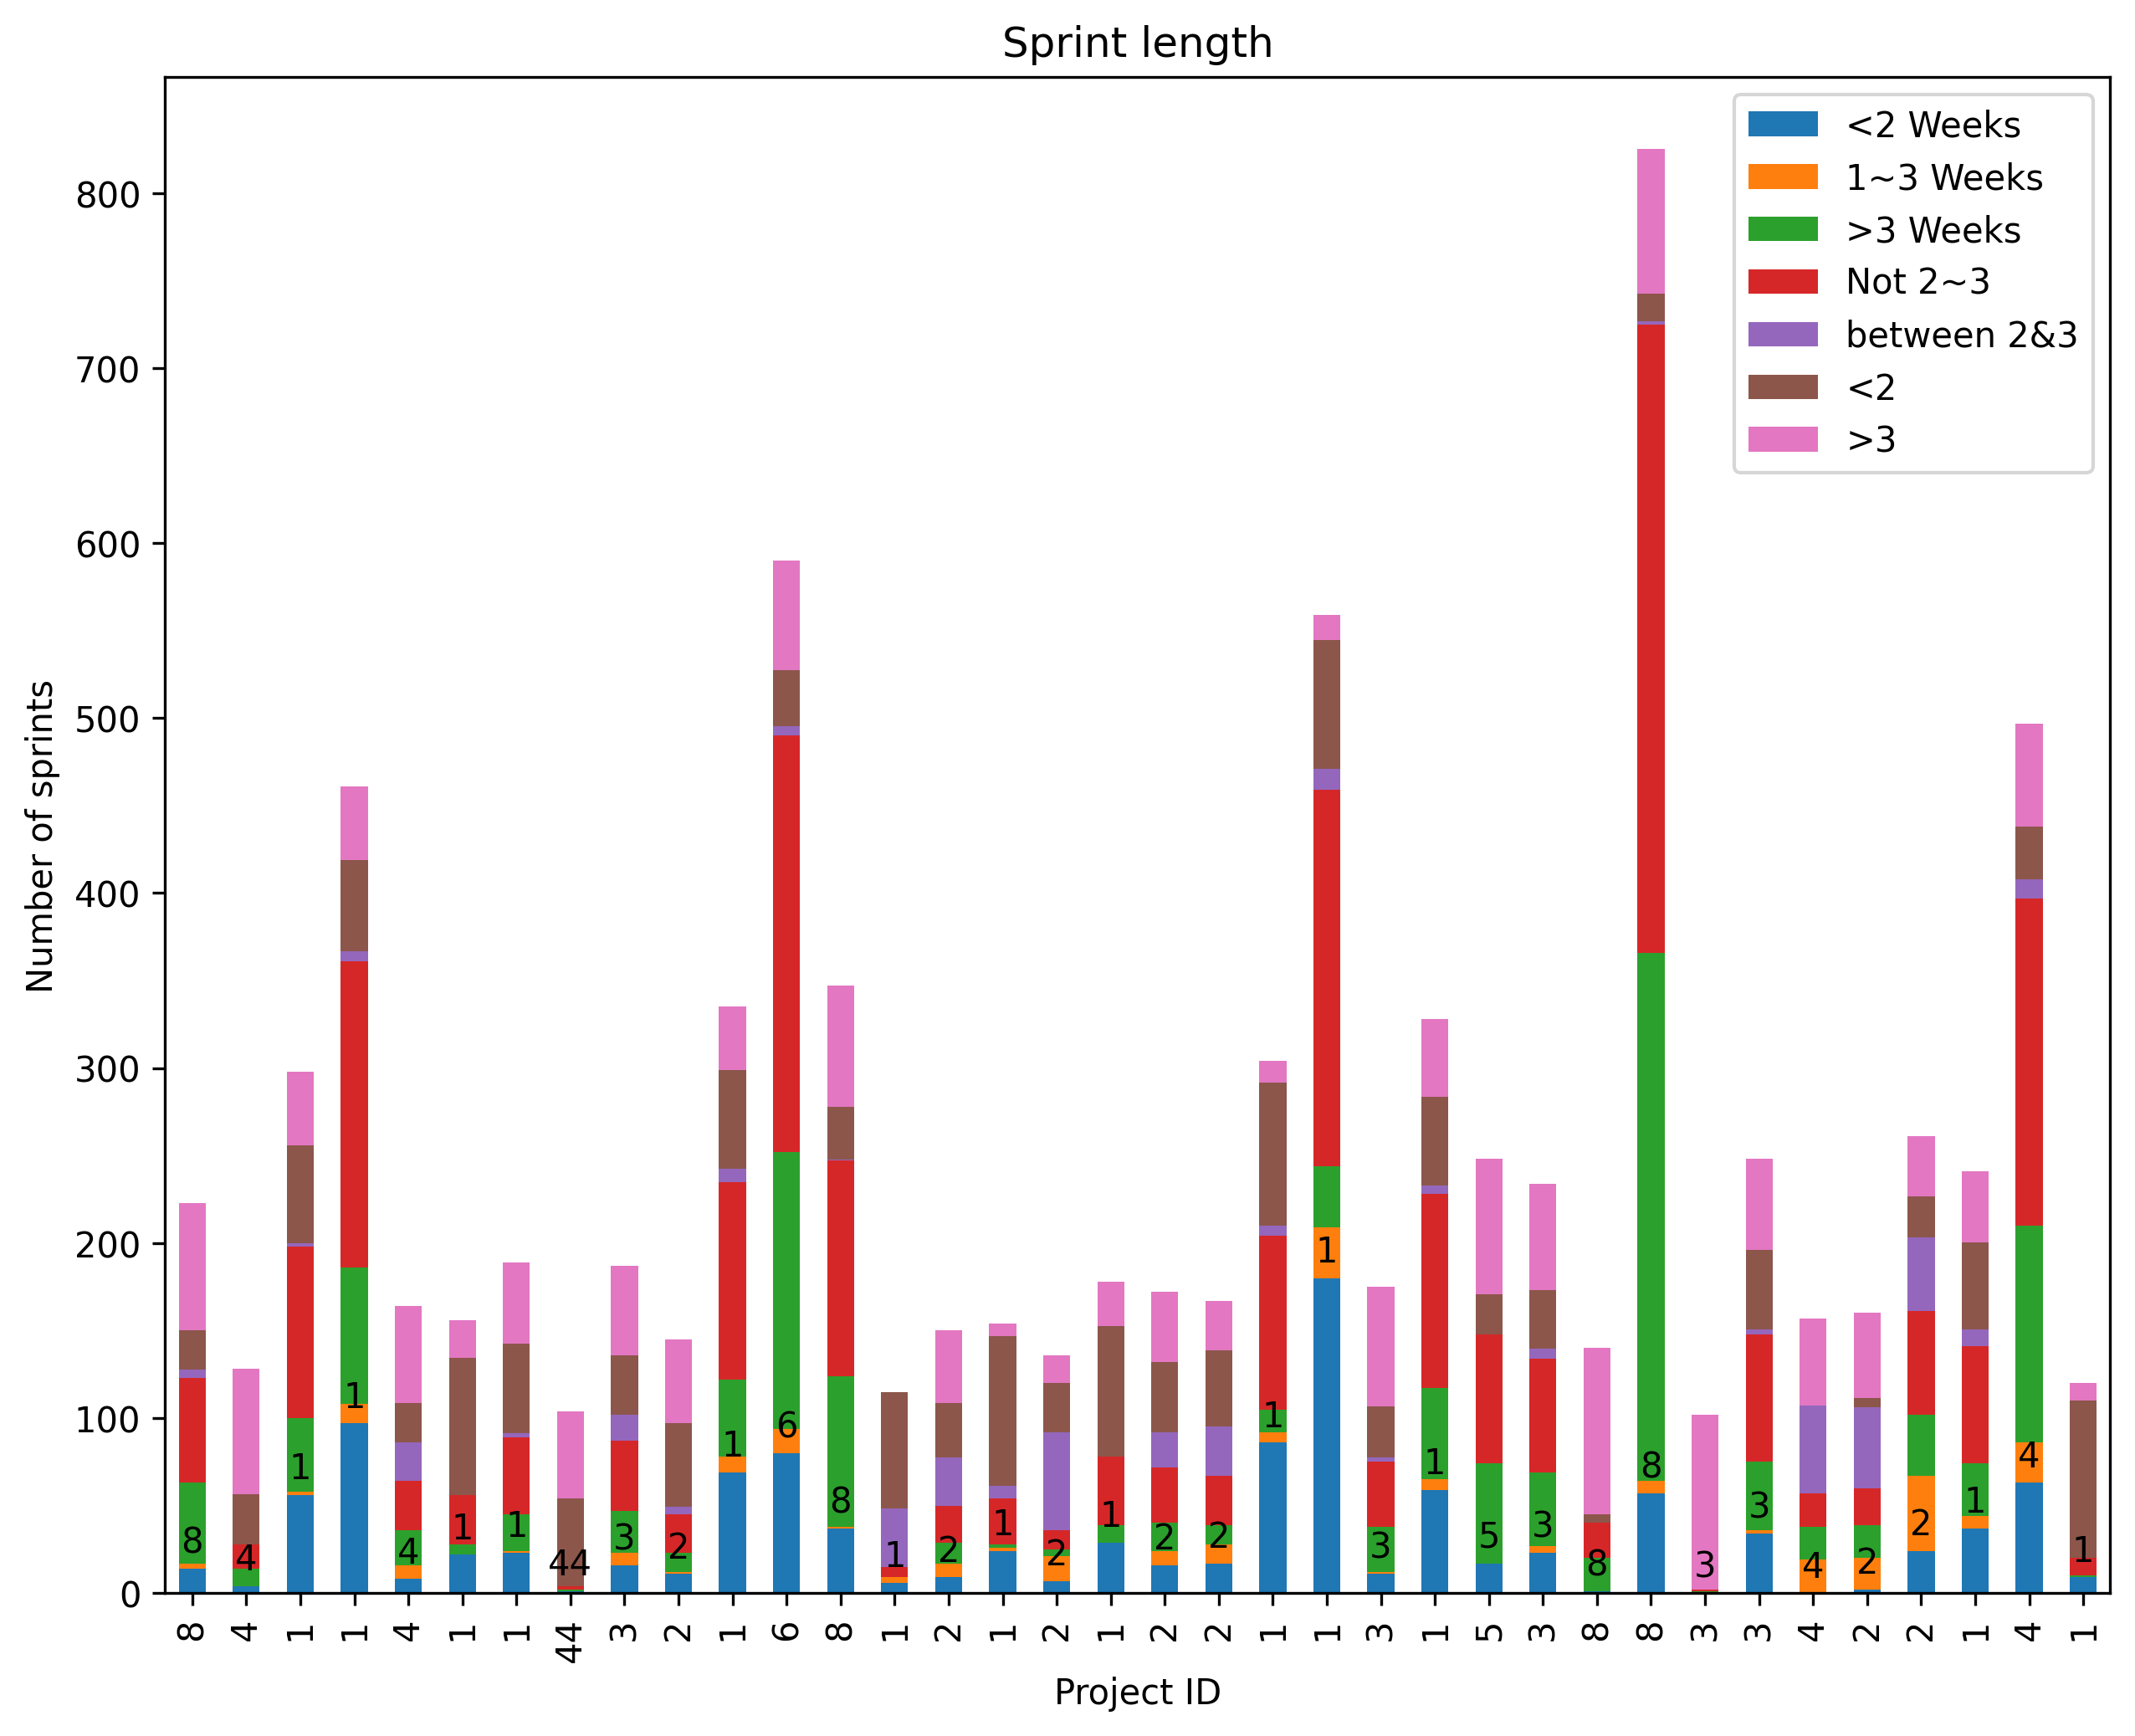

In [ ]:
ax = week_num.plot.bar(x='Project_ID', stacked=True, title= "Distribution of Each Project's Sprint")

plt.rcParams["figure.figsize"] = (10, 8)
# Add labels
# plt.ylabel('Number of sprints')
# plt.xlabel('Project ID')
# plt.legend(title='Sprint length')
ax.set_title("Sprint length")
ax.set_xlabel("Project ID")
ax.set_ylabel("Number of sprints")
ax.set_xticklabels(project_median)

rects = ax.patches

# labels = [f"label{i}" for i in range(len(rects))]

for rect, m in zip(rects, project_median):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, m, ha="center", va="bottom"
    )

# Show the chart
plt.show()

In [ ]:
# for i,d in df_dup.groupby("Project_ID"):
#   sprint_lengths = []
#   for j,s in d.groupby("Sprint_ID"):
#     mind = min(s["Start_Date"])
#     maxd = max(s["End_Date"])
#     print(f"Project {i} sprint {j}: {mind} -> {maxd} = {(maxd-mind).ceil('d').days} days")
#     sprint_lengths.append(maxd - mind)
#   sl_days = [i.ceil('d').days for i in sprint_lengths]
#   sl_days = [i for i in sl_days if str(i) != 'nan'] #???
#   b = max(sl_days) - min(sl_days)
#   b = b if b>0 else 1 #???
#   plt.hist(sl_days, density=True, bins=b)
#   plt.title(f"Project {i}")
#   plt.show()

#### Split large issues into smaller ones

In [ ]:
print('Epics -- Issues linked to an epic -- Issues linked to an epic (excluding Stories) -- Stories linked to an epic -- Unlinked stories')
print('==================================================================================================================================')

# display(df_linked.query("Has_Sprint == 0"))

for i,j in df_linked.groupby("Project_ID"):
  epics_of_p_i = j.query("Issue_Type == 'Epic'")
  linked_issues_of_p_i = j.query("Has_Linked_Epic == 1")
  linked_issues_not_story_of_p_i = j.query("Has_Linked_Epic == 1 and not Issue_Type =='Story'")
  linked_stories_of_p_i = j.query("Issue_Type == 'Story' and Has_Linked_Epic == 1")
  unlinked_stories_of_p_i = j.query("Issue_Type == 'Story' and Has_Linked_Epic == 0")
  num_issues = j.shape[0]

  print(f'  Project {i}: {epics_of_p_i.shape[0]} -- {linked_issues_of_p_i.shape[0]} -- {linked_issues_not_story_of_p_i.shape[0]} -- {linked_stories_of_p_i.shape[0]} -- {unlinked_stories_of_p_i.shape[0]}')

Epics -- Issues linked to an epic -- Issues linked to an epic (excluding Stories) -- Stories linked to an epic -- Unlinked stories
  Project 1: 112 -- 9 -- 0 -- 9 -- 2798
  Project 2: 0 -- 0 -- 0 -- 0 -- 0
  Project 3: 9 -- 7 -- 7 -- 0 -- 317
  Project 4: 568 -- 460 -- 443 -- 17 -- 205
  Project 5: 82 -- 17 -- 3 -- 14 -- 851
  Project 6: 37 -- 6 -- 6 -- 0 -- 115
  Project 7: 16 -- 14 -- 9 -- 5 -- 282
  Project 8: 25 -- 22 -- 15 -- 7 -- 650
  Project 9: 1 -- 0 -- 0 -- 0 -- 49
  Project 10: 19 -- 16 -- 15 -- 1 -- 32
  Project 11: 22 -- 13 -- 4 -- 9 -- 501
  Project 12: 300 -- 251 -- 200 -- 51 -- 2003
  Project 13: 84 -- 61 -- 19 -- 42 -- 1387
  Project 14: 0 -- 0 -- 0 -- 0 -- 0
  Project 15: 0 -- 0 -- 0 -- 0 -- 0
  Project 16: 0 -- 0 -- 0 -- 0 -- 0
  Project 17: 0 -- 0 -- 0 -- 0 -- 0
  Project 18: 0 -- 0 -- 0 -- 0 -- 0
  Project 19: 0 -- 0 -- 0 -- 0 -- 0
  Project 20: 0 -- 0 -- 0 -- 0 -- 0
  Project 21: 0 -- 0 -- 0 -- 0 -- 0
  Project 22: 0 -- 0 -- 0 -- 0 -- 0
  Project 23: 21 -- 8 -- 8 

In [ ]:
# # Drop rows without value
# sprint_week = df_dup[["Sprint_ID","Start_Date","End_Date","Project_ID"]].dropna()
# week_num = pd.DataFrame(columns =  ["Project_ID", "1~4 Weeks", ">4 Weeks"])
# for i,j in sprint_week.groupby("Project_ID"):
#   less_than_four = 0
#   more_than_four = 0
#   for s,t in j.groupby("Sprint_ID"):
#     mind = min(t["Start_Date"])
#     maxd = max(t["End_Date"])
#     week = (maxd-mind).days/7
#     if week > 4:
#       more_than_four = more_than_four + 1
#     else:
#       less_than_four = less_than_four + 1
#   week_num.loc[len(week_num)] = [i, more_than_four, less_than_four]
# # print(week_num)

# week_num.plot.bar(x='Project_ID', stacked=True, title= "Distribution of Each Project's Sprint")

# # Add labels
# plt.ylabel('Number of sprints')
# plt.xlabel('Project ID')
# plt.legend(title='Sprint length')

# # Show the chart
# plt.show()

#### Try to avoid tech stories

TODO: 
Determine per project, the number of sprints that have at least 1 tech story.
The following types are considered as tech stories: technical task, technical debt, suggestion and wish.



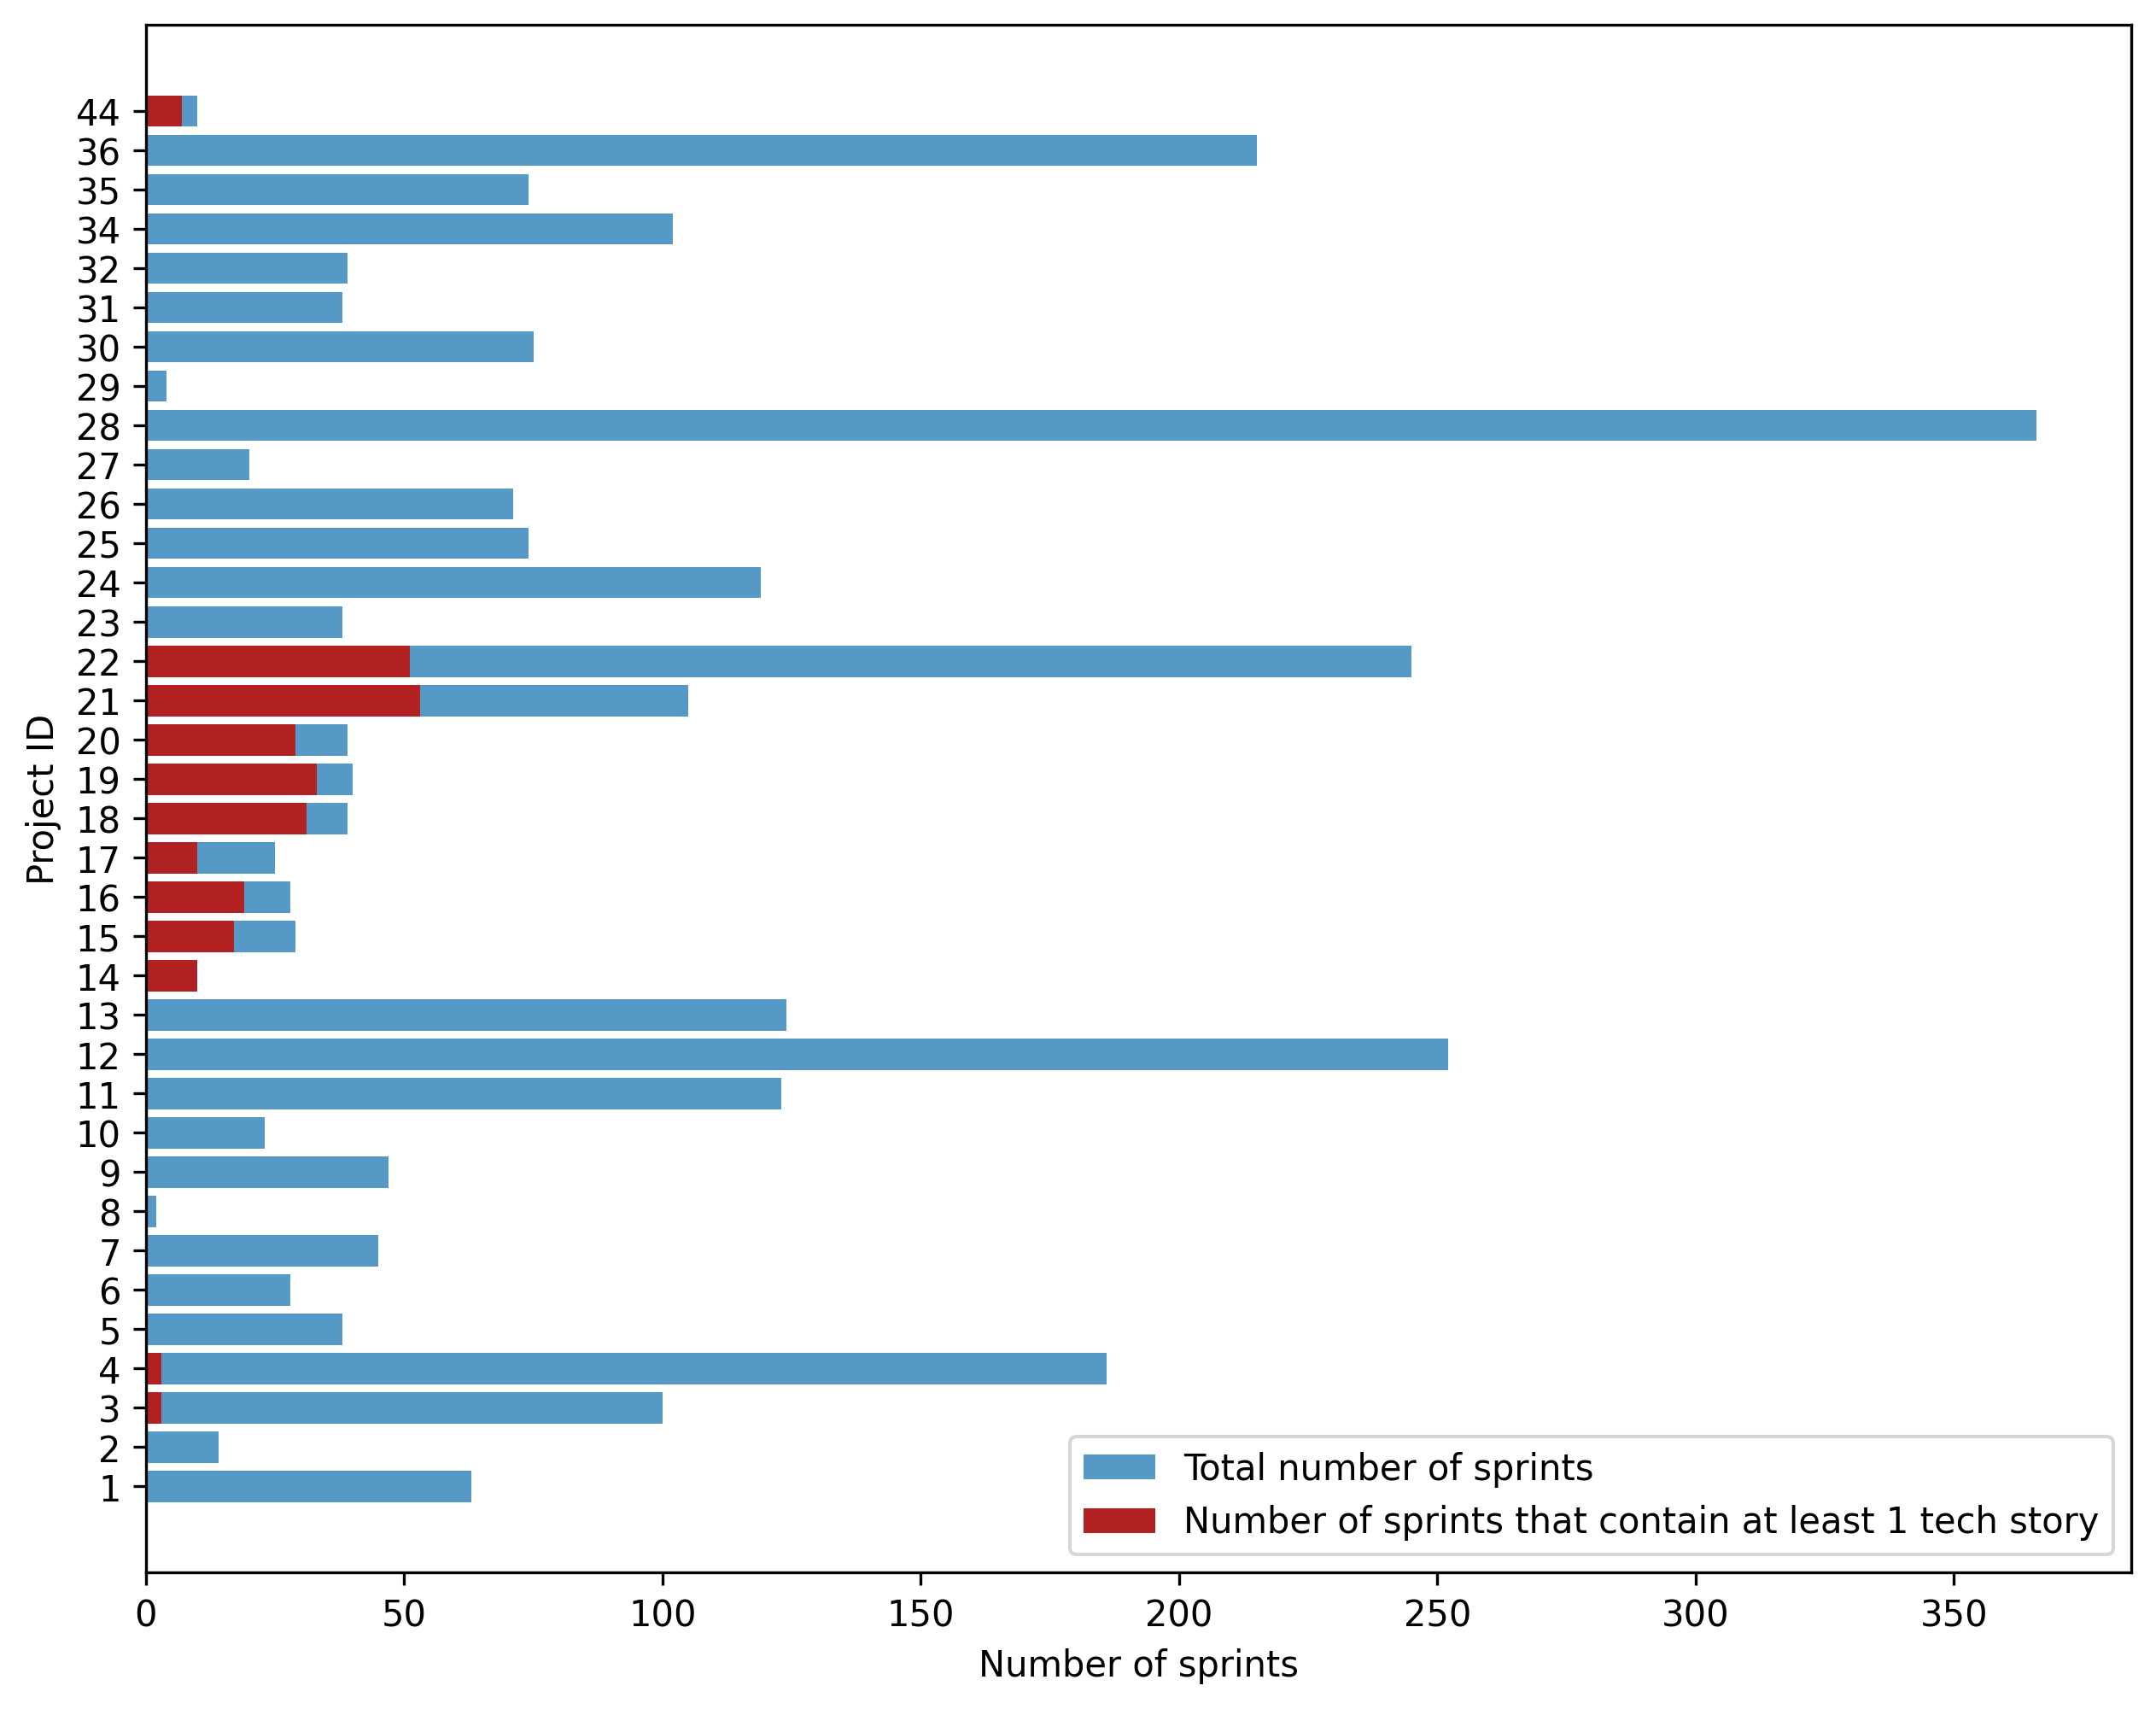

In [ ]:
# Filter out every issue that is not of type tech story.
df_tech_stories = df_dup.query("Type == 'Technical Task' | Type == 'Technical Debt' | Type == 'Wish' | Type == 'Suggestion'")[['Project_ID', 'Sprint_ID', 'Type']]

# Determine for per project, the number of sprints that contain at least 1 tech story.
sprints_per_project = [(i, len(pd.unique(j["Sprint_ID"]))) for i,j in df_dup.groupby('Project_ID')]
sprints_that_have_tech_stories_per_project = [(i, len(pd.unique(j["Sprint_ID"]))) for i,j in df_tech_stories.groupby('Project_ID')]

# Get data in right format (e.g. project 1 does not have tech story so need to insert (1,0) into the list).
projectIDs = sorted(df_dup['Project_ID'].unique())
tech_story_dict = dict(sprints_that_have_tech_stories_per_project)
for id in projectIDs:
    if not id in tech_story_dict:
        tech_story_dict[id] = 0
tech_story_dict = dict(sorted(tech_story_dict.items()))
sprints_that_have_tech_stories_per_project2 = list(tech_story_dict.items())

# Visualize, per project, number of sprints that contain tech stories.
sprints_per_project = [(i, len(pd.unique(j["Sprint_ID"]))) for i,j in df_dup.groupby('Project_ID')]
x = [i for i in range(len(sprints_per_project))]
h = [i for _,i in sprints_per_project]
l = [i for i,_ in sprints_per_project]
x2 = [i for i in range(len(sprints_that_have_tech_stories_per_project2))]
h2 = [i for _,i in sprints_that_have_tech_stories_per_project2]
l2 = [i for i,_ in sprints_that_have_tech_stories_per_project2]

plt.rcParams["figure.figsize"] = (10, 8)
plt.barh(x, h, alpha=0.75, label='Total number of sprints')
plt.barh(x2,h2, color='firebrick', label='Number of sprints that contain at least 1 tech story')
# plt.title("Percentage of sprints that contain at least 1 tech story per project")
plt.xlabel("Number of sprints")
plt.ylabel("Project ID")
plt.legend()
plt.yticks(x, [f"{l[i]}" for i in range(len(l))])

# for i in [i for _,i in [sorted(zip(h, x))[i] for i in range(-3, 3)]]:
#   plt.annotate(h[i], xy=(h[i], x[i]), ha='left', va='center')

plt.show()

#### Fibonacci

TODO: Make pie chart of distribution of 4 labels:
- Fibonacci: Fibonacci sequence + 0 and 0.5 since these are also included in the book.
- Almost Fibonacci: similar to Fibonacci but missing a few numbers, a few numbers extra OR Modified Fibonacci, e.g. 0, 1, 2, 3, 5, 8, 13, 20, 40, 100.
- Includes Fibonacci: contains the Fibonacci sequence but als many other numbers.
- Not Fibonacci: not Fibonacci, number of story points too little (less than 5) or not used at all.

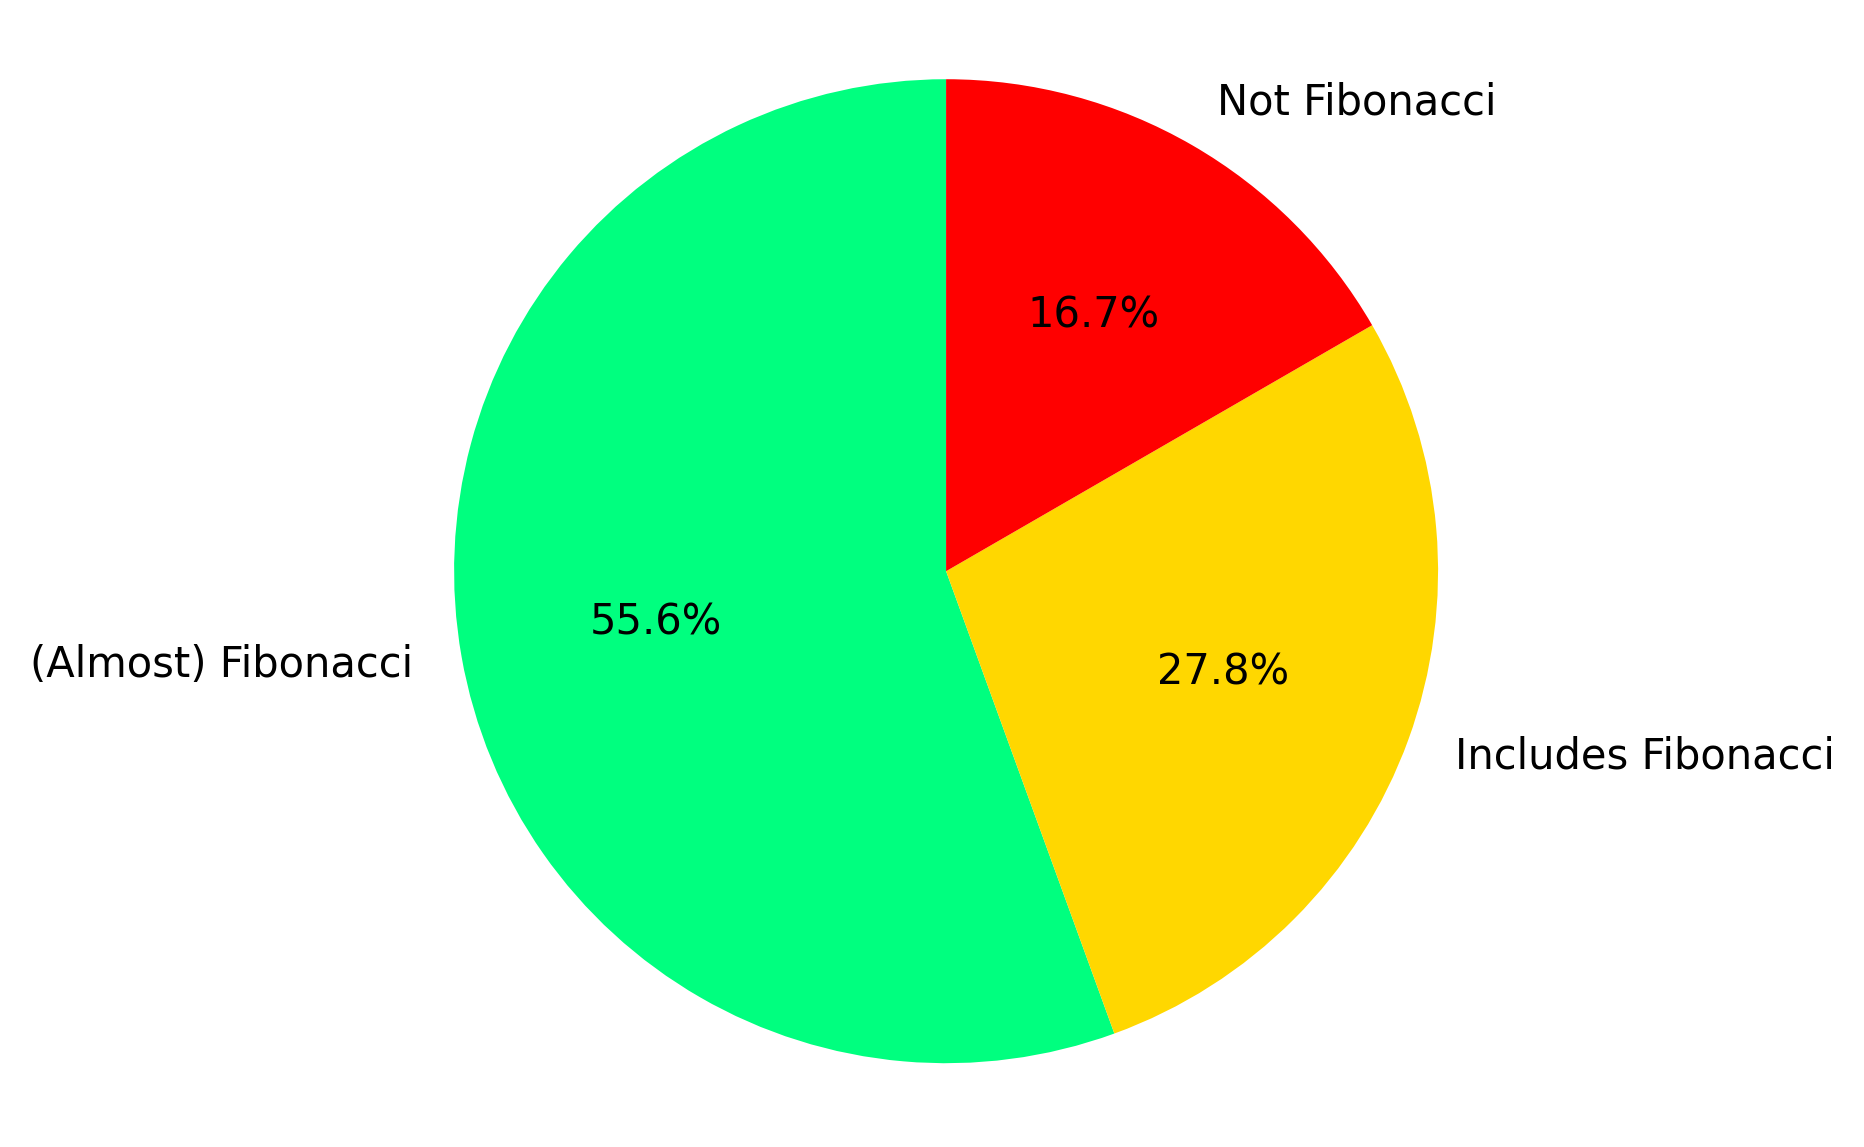

In [ ]:
# Print unique story points used in each project.
# for i,d in df_dup.groupby("Project_ID"):
#   print(f"{i}: {sorted([i for i in pd.unique(d['Story_Point']) if i == i])}")

# Manually label the usage of story points per project.
labels_dict = {
    1:'includes_fibo', 2:'almost_fibo', 3:'fibo', 4:'includes_fibo', 5:'fibo', 6:'almost_fibo', 7:'fibo', 8:'not_fibo', 9:'fibo', 10:'almost_fibo',
    11:'includes_fibo', 12:'includes_fibo', 13:'almost_fibo', 14:'not_fibo', 15:'almost_fibo', 16:'includes_fibo', 17:'almost_fibo', 18:'almost_fibo', 
    19:'almost_fibo', 20:'almost_fibo', 21:'almost_fibo', 22:'fibo', 23:'includes_fibo', 24:'includes_fibo', 25:'fibo', 26:'includes_fibo', 27:'fibo', 
    28:'not_fibo', 29:'not_fibo', 30:'fibo', 31:'fibo', 32:'not_fibo', 34:'includes_fibo', 35:'almost_fibo', 36:'includes_fibo', 44:'not_fibo'
}

# Visualize distribution of usage in a pie chart.
labels = ['fibo', 'almost_fibo', 'includes_fibo', 'not_fibo']

pie_labels = ['Fibonacci', 'Almost Fibonacci', 'Includes Fibonacci', 'Not Fibonacci']
counts = np.zeros(len(labels))

for key in labels_dict:
    for i in range(len(labels)):
        if labels_dict[key] == labels[i]:
            counts[i] += 1

merged_pie_labels = ['(Almost) Fibonacci', 'Includes Fibonacci', 'Not Fibonacci']
merged_counts = np.zeros(len(labels) - 1)
merged_counts[0] = counts[0] + counts[1]
merged_counts[1] = counts[2]
merged_counts[2] = counts[3]

plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.pie(merged_counts, labels=merged_pie_labels, autopct='%1.1f%%', startangle=90, colors=['springgreen', 'gold', 'red'])
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.title('Distribution of Fibonacci usage')
plt.show()


#### Slack Time

In [ ]:
import datetime as dt

# Remove nan values
sprint_time = df_dup[["Sprint_ID","Start_Date","End_Date","Project_ID"]].dropna()

# Empty df to store project_ID and gaps of each project
time_gap = pd.DataFrame(columns =  ["Project_ID", "Gap"])

for i,v in sprint_time.groupby("Project_ID"):
  # Empty df to store start and end date of each project
  gaps = pd.DataFrame(columns =  ["Start_Date", "End_Date"])
  # Start and end date of each sprint
  for s,t in v.groupby("Sprint_ID"):
    mind = min(t["Start_Date"])
    maxd = max(t["End_Date"])
    gaps.loc[len(gaps)] = [mind, maxd]
  # Sort the df by their start date
  gaps = gaps.sort_values(by="Start_Date")
  # Sum of the date gap between each sprint
  dates_range = pd.Timedelta(0)
  # print(i, len(gaps))

  # Project 29 only contains 1 sprint, which means there is no gap
  for j in range(len(gaps)-1):
    # Next sprint start date - current end date
    gap_days =  gaps.iloc[j+1]['Start_Date'] - gaps.iloc[j]['End_Date']
    # print(gap_days)
    if gap_days > dt.timedelta(days=0):
      dates_range = dates_range + gap_days
  if len(gaps) > 1:
    dates_range = dates_range / (len(gaps) - 1) # Convert to average.
  time_gap.loc[len(time_gap)] = [i, dates_range]
  # time_gap["Gap"] = pd.to_numeric(pd.to_datetime(time_gap['Gap']), downcast='integer')
# print(time_gap['Gap'].dt.total_seconds())
time_gap['Gap'] = time_gap['Gap'].dt.total_seconds() / 86400
# time_gap['Gap'] = time_gap['Gap'].astype(int)
# print(time_gap)
print(time_gap[time_gap['Gap']<=2].shape[0])
print(time_gap[(time_gap['Gap']>2) & (time_gap['Gap']<7)].shape[0])

7
10


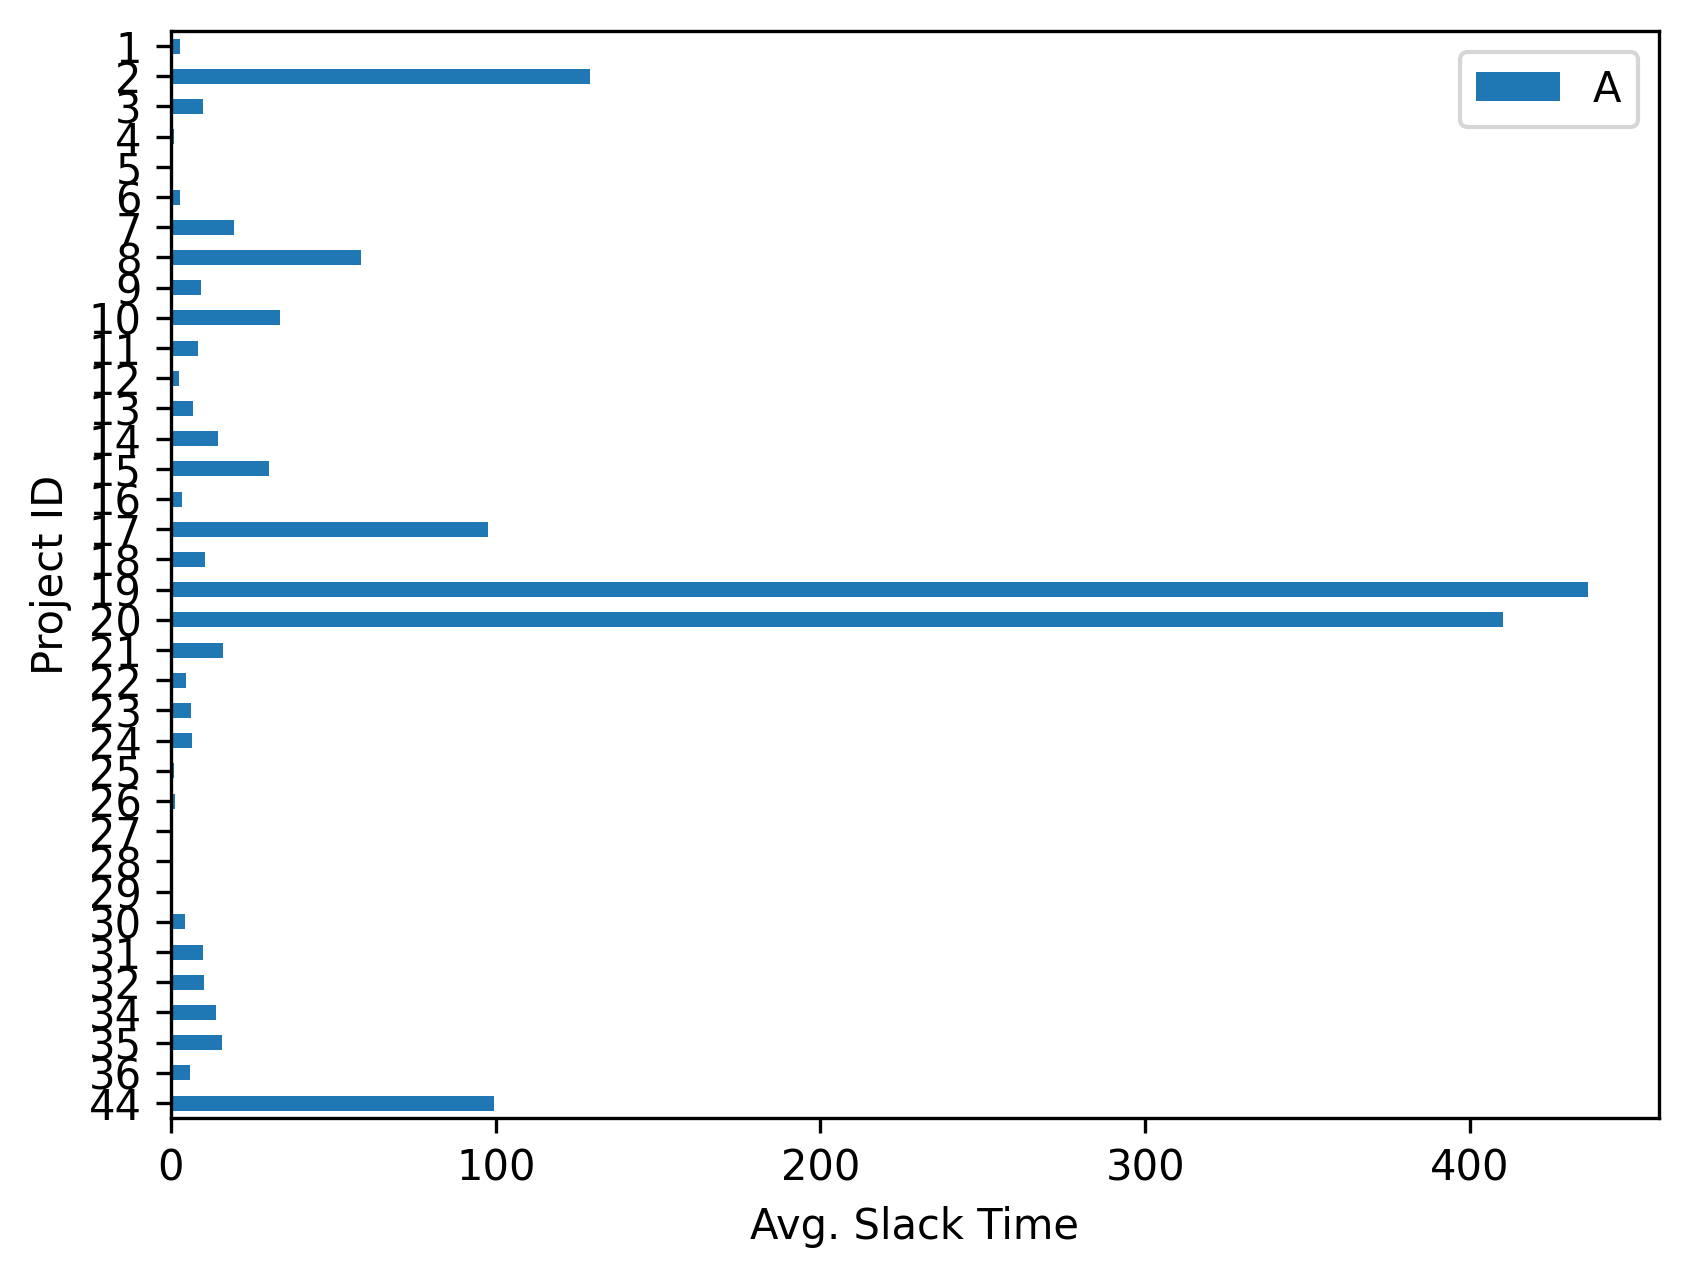

In [ ]:
time_gap.plot.barh(x='Project_ID').invert_yaxis()

# Add labels
plt.ylabel('Project ID')
plt.xlabel('Avg. Slack Time')
plt.legend("Average Slack Time of Each Project")

plt.show()

In [ ]:
# time_gap.loc[time_gap['Gap'] >= 1 & time_gap['Gap'] <= 3]
time_gap.loc[time_gap['Gap'] >= 1].loc[time_gap['Gap'] <= 3]
# df.loc[df['column_name'] == some_value]

,Project_ID,Gap
0,1,2.812582
5,6,2.753697
11,12,2.422065
25,26,1.396515


## RQ2

### Imports import imports imports imports imports

In [ ]:
#https://twitter.com/TSMReginald/status/1362949561682067457
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
from os.path import exists
from shutil import rmtree

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import chi2, SelectKBest, f_classif, RFE 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

### Get data and prepare

In [ ]:
# Remove folder if it was already there (only if you run it twice, naughty or nice)
if exists('data-testing'):
  rmtree('data-testing')

# Get data and unzip
!git clone https://github.com/martijnbroekman/data-testing
%cd data-testing

# 🐼
issues_frame = pd.read_csv('issue_data.csv')

Cloning into 'data-testing'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 33 (delta 11), reused 28 (delta 6), pack-reused 0
Unpacking objects: 100% (33/33), 31.17 MiB | 11.42 MiB/s, done.
/content/data-testing/data-testing


In [ ]:
list(issues_frame.columns)

['description_length',
 'type',
 'priority',
 'estimated_days',
 'story_points',
 'num_comments',
 'avg_comment_length',
 'sprint_days_given',
 'is_problematic']

In [ ]:
issues_frame.head

<bound method NDFrame.head of        description_length         type priority  estimated_days  story_points  \
0                     380  Improvement    Minor             0.0           1.0   
1                      14          Bug    Minor             0.0           1.0   
2                     575  Improvement    Minor             0.0           3.0   
3                    1562          Bug    Major             0.0           1.0   
4                     126          Bug    Minor             0.0           1.0   
...                   ...          ...      ...             ...           ...   
94199                 478          Bug      Low             0.0           4.0   
94200                 670   Suggestion      NaN             0.0           4.0   
94201                 842          Bug      Low             0.0           1.0   
94202                 475          Bug      Low             0.0           4.0   
94203                 522   Suggestion      NaN             0.0           2.0  

In [ ]:
issues_frame.isna().sum()

description_length        0
type                      0
priority              26228
estimated_days        23438
story_points          23438
num_comments              0
avg_comment_length    19240
sprint_days_given      1343
is_problematic            0
dtype: int64

In [ ]:
issues_frame.dropna().head

<bound method NDFrame.head of        description_length type priority  estimated_days  story_points  \
3                    1562  Bug    Major             0.0           1.0   
4                     126  Bug    Minor             0.0           1.0   
5                     126  Bug    Minor             0.0           1.0   
9                     253  Bug    Minor             0.0           1.0   
15                    723  Bug    Major             0.0           1.0   
...                   ...  ...      ...             ...           ...   
94193                 585  Bug   Medium             0.0           5.0   
94197                 975  Bug      Low             0.0           2.0   
94199                 478  Bug      Low             0.0           4.0   
94201                 842  Bug      Low             0.0           1.0   
94202                 475  Bug      Low             0.0           4.0   

       num_comments  avg_comment_length  sprint_days_given  is_problematic  
3               

In [ ]:
# Imputation after more refinement of the data in RQ1
# Confirm that there is no correlation, then use median?
# Do we want to use the None priority for NaNs?
issues_frame_dropna = issues_frame.dropna()
real_data = issues_frame_dropna['is_problematic']
issues_frame_dropna = issues_frame_dropna.drop('is_problematic', axis=1)

### Clean data

In [ ]:
def replace(df, col, fromm, to):
  df.loc[df[col] == fromm, col] = to

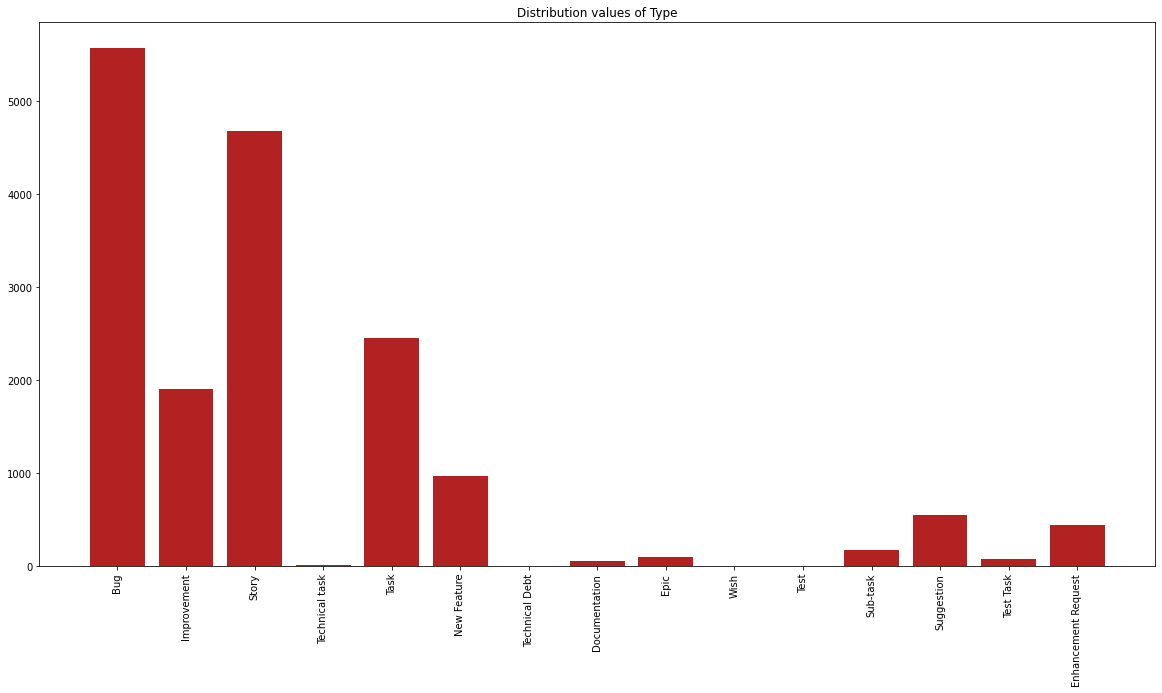

In [ ]:
# Merge types
# The really small ones are kind of garbage and only make the running time slower
print(issues_frame_dropna['type'].unique())
to_yeet = ['Technical task', 'Technical Debt', 'Wish', 'Test', 'Test Task']
yeet_to = 'Other'
for yeet_from in to_yeet:
  replace(issues_frame_dropna, 'type', yeet_from, yeet_to)
print(issues_frame_dropna['type'].unique())  

['Bug' 'Story' 'Improvement' 'Technical task' 'Epic' 'Task' 'New Feature'
 'Sub-task' 'Technical Debt' 'Documentation' 'Wish' 'Suggestion'
 'Enhancement Request']
['Bug' 'Story' 'Improvement' 'Other' 'Epic' 'Task' 'New Feature'
 'Sub-task' 'Documentation' 'Suggestion' 'Enhancement Request']


In [ ]:
# Merge priorities
print(issues_frame_dropna['priority'].unique())
# None
# To be reviewed
# P1      P2       P3    P4    P5
# Blocker Critical Major Minor Trivial
# Highest High     Medium Low  Lowest
#   ---> Threat to validity: Major feels very different from Medium so this replacement might not be 100% kosher
froms = [['Blocker - P1', 'Critical - P2', 'Major - P3', 'Minor - P4', 'Trivial - P5'], ['Blocker', 'Critical', 'Major', 'Minor', 'Trivial']]
t = ['Highest', 'High', 'Medium', 'Low', 'Lowest']
for f in froms:
  for i in range(5):
    replace(issues_frame_dropna, 'priority', f[i], t[i])
print(issues_frame_dropna['priority'].unique())

['Major' 'Minor' 'Trivial' 'Critical' 'Blocker' 'None' 'High' 'Medium'
 'Low' 'Highest' 'Lowest' 'Major - P3' 'Critical - P2' 'Minor - P4'
 'Trivial - P5' 'To be reviewed']
['Medium' 'Low' 'Lowest' 'High' 'Highest' 'None' 'To be reviewed']


In [ ]:
# NaN avg length -> zero
issues_frame['avg_comment_length'] = issues_frame['avg_comment_length'].fillna(0)

### Sklearnify the data

In [ ]:
X = issues_frame_dropna
y = real_data

cols = list(issues_frame_dropna.columns)
# Look at the categorical data and decide on OneHot or Ordinal
print(X.type.unique())
print(X.priority.unique())
enc = OneHotEncoder()

column_transformer_all = ColumnTransformer(
    [
        # Preserve order for my sanity
        ("pass", "passthrough", cols[:1]),
        ("type_encoder", enc, ["type"]),
        ("priority_encoder", enc, ["priority"]),
        ("pâss", "passthrough", cols[3:]),
    ]
)

column_transformer_cat = ColumnTransformer(
    [
        # Preserve order for my sanity
        #("pass", "passthrough", cols[:1]),
        ("type_encoder", enc, ["type"]),
        ("priority_encoder", enc, ["priority"]),
        #("pass2", "passthrough", cols[3:]),
    ]
)

column_transformer_num = ColumnTransformer(
    [
        # Preserve order for my sanity
        ("pass", "passthrough", cols[:1]),
        #("type_encoder", OrdinalEncoder(), ["type"]),
        #("priority_encoder", OrdinalEncoder(), ["priority"]),
        ("pâss", "passthrough", cols[3:]),
    ]
)

X_num = column_transformer_num.fit_transform(X)
X_cat = column_transformer_cat.fit_transform(X)
X_all = column_transformer_all.fit_transform(X)
numerical_features = column_transformer_num.get_feature_names_out()
OrdinalEncoder.get_feature_names_out = (lambda self, names=None: # Why is this not implemented????
                                        self.feature_names_in_)
categorical_features = column_transformer_cat.get_feature_names_out()
all_features = column_transformer_all.get_feature_names_out()

['Bug' 'Story' 'Improvement' 'Other' 'Epic' 'Task' 'New Feature'
 'Sub-task' 'Documentation' 'Suggestion' 'Enhancement Request']
['Medium' 'Low' 'Lowest' 'High' 'Highest' 'None' 'To be reviewed']


### F-test and $\chi^2$-test

In [ ]:
alpha = 0.05
all_results = []

f_results = SelectKBest(f_classif, k="all").fit(X_num, y)
idx = np.argsort(f_results.scores_)
for i in idx[::-1]:
  #print(f"{numerical_features[i]}: {f_results.scores_[i]}, p={f_results.pvalues_[i]}")
  all_results.append( (numerical_features[i], f_results.scores_[i], f_results.pvalues_[i]) )

#print('')

chi_results = SelectKBest(chi2, k="all").fit(X_cat, y)
idx = np.argsort(chi_results.scores_)
for i in idx[::-1]:
  #print(f"{categorical_features[i]}: {chi_results.scores_[i]}, p={chi_results.pvalues_[i]}")
  all_results.append( (categorical_features[i], chi_results.scores_[i], chi_results.pvalues_[i]) )

#print('')

tab = '\t'
for a, b, c in sorted(all_results, key=lambda x: x[2], reverse=False):
  print(f"{a}:{tab+tab+tab+tab if len(a)<23 else tab+tab+tab if len(a)<31 else tab+tab if len(a)<41 else tab} {b}, {tab} p={c}") # Don't ask

priority_encoder__priority_Medium:		 495.60139431078613, 	 p=8.610462792502808e-110
type_encoder__type_Task:			 479.519426269832, 	 p=2.7184136880233445e-106
pâss__num_comments:				 460.51571168387, 	 p=1.550586866266609e-101
priority_encoder__priority_Low:			 224.9910308402592, 	 p=7.37507753887029e-51
type_encoder__type_Bug:				 215.54465907079097, 	 p=8.477179729700854e-49
type_encoder__type_Story:			 153.5570622140969, 	 p=2.894204257265424e-35
priority_encoder__priority_High:		 152.68330972235205, 	 p=4.4924738204485105e-35
type_encoder__type_New Feature:			 76.92964260409754, 	 p=1.7715805000489038e-18
priority_encoder__priority_None:		 59.57929940200656, 	 p=1.1746425117949213e-14
type_encoder__type_Sub-task:			 52.9999537190112, 	 p=3.335562255654079e-13
type_encoder__type_Epic:			 52.9977945070702, 	 p=3.339230960319456e-13
pâss__avg_comment_length:			 51.528278479201795, 	 p=7.190119896823243e-13
type_encoder__type_Documentation:		 47.10642929230063, 	 p=6.723477778430593e-12

### Recursive Feature Elimination

In [ ]:
model = RandomForestClassifier(n_estimators=200, max_depth=8)
eliminated = [False for i in range(len(all_features))]
def funky(model):
  fi = model.feature_importances_
  count = 0
  toprint = "["
  smallest = 2
  smallest_i = -1
  for i,b in enumerate(eliminated):
    if b:
      toprint += "--X--, "
    else:
      if fi[count] < smallest:
        smallest = fi[count]
        smallest_i = i
      toprint += '{0:.3f}'.format(fi[count]) + ", "
      count += 1
  toprint = toprint[:len(toprint)-2] + "]"
  print(toprint)
  eliminated[smallest_i] = True
  return fi
rfe = RFE(model, n_features_to_select=1, importance_getter=funky)
#print(" des_l, t_Bug, t_Doc, t_Enh, t_Epi, t_Imp, t_New, t_Sty, t_Sub, t_Tsk, t_TDb, t_TTs, t_Wsh, p_Blk, p_Cri, p_CP2, p_Hig, p_Hst, p_Low, p_Lws, p_Maj, p_MP3, p_Med, p_Min, p_MP4, p_Non, p_tbr, p_Trv, p_TP5, est_d, sty_p, num_c, avgcl, sprdg ") # <- Outdated
print(" des_l, t_Bug, t_Doc, t_Enh, t_Epc, t_Imp, t_NwF, t_Oth, t_Sty, t_Sub, t_Sug, t_Tsk, p_Hig, p_Hst, p_Low, p_Lst, p_Med, p_Non, p_TBR, est_d, sty_p, num_c, avgcl, sprdg")
rfe_ranking = rfe.fit(X_all, y).ranking_

print("\nWorst to best:")
for i in np.argsort(rfe_ranking)[::-1]:
  print(all_features[i])

 des_l, t_Bug, t_Doc, t_Enh, t_Epc, t_Imp, t_NwF, t_Oth, t_Sty, t_Sub, t_Sug, t_Tsk, p_Hig, p_Hst, p_Low, p_Lst, p_Med, p_Non, p_TBR, est_d, sty_p, num_c, avgcl, sprdg
[0.094, 0.054, 0.004, 0.004, 0.005, 0.008, 0.010, 0.003, 0.030, 0.005, 0.000, 0.058, 0.026, 0.005, 0.044, 0.002, 0.122, 0.006, 0.003, 0.003, 0.118, 0.142, 0.132, 0.123]
[0.093, 0.056, 0.004, 0.004, 0.004, 0.008, 0.009, 0.002, 0.033, 0.006, --X--, 0.057, 0.028, 0.005, 0.045, 0.002, 0.118, 0.005, 0.003, 0.002, 0.118, 0.144, 0.130, 0.124]
[0.095, 0.056, 0.003, 0.004, 0.004, 0.009, 0.010, 0.002, 0.029, 0.004, --X--, 0.059, 0.027, 0.006, 0.043, --X--, 0.113, 0.005, 0.003, 0.002, 0.123, 0.147, 0.131, 0.124]
[0.103, 0.048, 0.003, 0.004, 0.004, 0.009, 0.010, 0.002, 0.030, 0.005, --X--, 0.059, 0.024, 0.005, 0.041, --X--, 0.117, 0.004, 0.003, --X--, 0.122, 0.143, 0.136, 0.129]
[0.098, 0.051, 0.003, 0.004, 0.004, 0.009, 0.009, --X--, 0.032, 0.005, --X--, 0.060, 0.023, 0.005, 0.039, --X--, 0.114, 0.004, 0.003, --X--, 0.128, 0.146, 0

### Permutation Importance

In [ ]:
# Make an okay classifier first to tune parameters
from sklearn.model_selection import cross_val_score
# RandomForestClassifier() kinda crap but better than nothing 60%
# SVC() consistenly around 60% absolutely terrible lol, changing C doesn't even work
#model = SVC(kernel='rbf', C=1.0, gamma=1)
model = RandomForestClassifier(n_estimators=200, max_depth=8)
print(f"{model}: {cross_val_score(model, X_all, y, cv=5, scoring='f1', n_jobs=-1)}")

RandomForestClassifier(max_depth=8, n_estimators=200): [0.71971136 0.69422518 0.71991187 0.57069708 0.71075581]


In [ ]:
models = [RandomForestClassifier(n_estimators=200, max_depth=8), ] # oh god SVC is slow wtf
scorers = ['accuracy', 'f1']
header = ["des_l", "t_Bug", "t_Doc", "t_Enh", "t_Epc", "t_Imp", "t_NwF", "t_Oth", "t_Sty", "t_Sub", "t_Sug", "t_Tsk", "p_Hig", "p_Hst", "p_Low", "p_Lst", "p_Med", "p_Non", "p_TBR", "est_d", "sty_p", "num_c", "avgcl", "sprdg"]
for model in models:
  for scorer in scorers:
    model = model.fit(X_all, y)
    print(model, scorer)                             
    mean_scores = list(permutation_importance(model, X_all, y, scoring=scorer).importances_mean)
    print(f" {'  '.join(header)}")
    print(f"[{', '.join(['%.3f' % x for x in mean_scores])}]")
    print()
    idx = np.argsort(mean_scores)
    print(f" {'  '.join([header[i] for i in idx[::-1]])}")
    print(f"[{', '.join(['%.3f' % x for x in sorted(mean_scores, reverse=True)])}]")
    print()

#print(" des_l, t_Bug, t_Doc, t_Enh, t_Epc, t_Imp, t_NwF, t_Oth, t_Sty, t_Sub, t_Tsk, p_Hig, p_Hst, p_Low, p_Lst, p_Med, p_Non, p_TBR, est_d, sty_p, num_c, avgcl, sprdg")
#print(" des_l,  type, prior, est_d, sty_p, num_c, avgcl, sprdg ")

RandomForestClassifier(max_depth=8, n_estimators=200) accuracy
 des_l  t_Bug  t_Doc  t_Enh  t_Epc  t_Imp  t_NwF  t_Oth  t_Sty  t_Sub  t_Sug  t_Tsk  p_Hig  p_Hst  p_Low  p_Lst  p_Med  p_Non  p_TBR  est_d  sty_p  num_c  avgcl  sprdg
[0.022, 0.017, 0.001, 0.001, 0.001, 0.002, 0.003, 0.001, 0.007, 0.001, 0.000, 0.012, 0.013, 0.002, 0.009, 0.001, 0.032, 0.001, 0.002, 0.001, 0.032, 0.034, 0.022, 0.019]

 num_c  sty_p  p_Med  avgcl  des_l  sprdg  t_Bug  p_Hig  t_Tsk  p_Low  t_Sty  t_NwF  p_TBR  t_Imp  p_Hst  t_Sub  p_Non  t_Doc  t_Epc  t_Enh  est_d  p_Lst  t_Oth  t_Sug
[0.034, 0.032, 0.032, 0.022, 0.022, 0.019, 0.017, 0.013, 0.012, 0.009, 0.007, 0.003, 0.002, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.000]

RandomForestClassifier(max_depth=8, n_estimators=200) f1
 des_l  t_Bug  t_Doc  t_Enh  t_Epc  t_Imp  t_NwF  t_Oth  t_Sty  t_Sub  t_Sug  t_Tsk  p_Hig  p_Hst  p_Low  p_Lst  p_Med  p_Non  p_TBR  est_d  sty_p  num_c  avgcl  sprdg
[0.016, 0.009, 0.001, 0.001, 0.001, 

### Analysis of results

In [ ]:
# What is the distribution of Medium for 0 or 1?
print("It's future work.")

It's future work.
